# Imports

In [1]:
import subprocess

In [2]:
import altair as alt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import tqdm

In [3]:
from utils import CHAR_LOOKUP, flatten_columns, get_datadir

In [4]:
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [5]:
alt.data_transformers.enable("data_server")
alt.renderers.enable("altair_saver", fmts=["png"], embed_options={"scaleFactor": "4"})

RendererRegistry.enable('altair_saver')

In [6]:
# allow pandas to show more data
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)

# Select year and load file

In [7]:
year: str = "2005-2006"

In [8]:
datadir = get_datadir(year)

In [9]:
xptfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}.xpt"
zipfilename = f"PAXRAW_{CHAR_LOOKUP[year].upper()}.ZIP"
zipfile = datadir / zipfilename
if not xptfile.exists():
    print("no extracted xpt file, looking for the zip")
    if not zipfile.exists():
        print("no zip exists, downloading it")
        subprocess.run(
            [
                "wget",
                "-O",
                zipfile,
                f"https://wwwn.cdc.gov/Nchs/Nhanes/{year}/{zipfilename}",
                "--no-use-server-timestamps",
            ]
        )
    print("extracting")
    subprocess.run(["unzip", "-o", zipfile, "-d", datadir])

In [10]:
paxraw = pd.read_sas(xptfile)

In [11]:
paxraw.shape

(74874095, 9)

In [12]:
paxraw.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,PAXSTEP
0,31128.0,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,1.660000e+02,4.000000e+00
1,31128.0,1.0,1.0,1.0,2.0,5.397605e-79,1.000000e+00,2.700000e+01,5.397605e-79
2,31128.0,1.0,1.0,1.0,3.0,5.397605e-79,2.000000e+00,5.397605e-79,5.397605e-79
3,31128.0,1.0,1.0,1.0,4.0,5.397605e-79,3.000000e+00,2.760000e+02,4.000000e+00
4,31128.0,1.0,1.0,1.0,5.0,5.397605e-79,4.000000e+00,5.397605e-79,5.397605e-79


## Fix datatypes

In [13]:
paxraw.dtypes

SEQN        float64
PAXSTAT     float64
PAXCAL      float64
PAXDAY      float64
PAXN        float64
PAXHOUR     float64
PAXMINUT    float64
PAXINTEN    float64
PAXSTEP     float64
dtype: object

In [14]:
for col in paxraw.columns:
    print(f"casting {col=} to int")
    try:
        paxraw.loc[:, col] = paxraw.loc[:, col].astype(int)
    except pd.errors.IntCastingNaNError:
        print(f"{col=} has {paxraw.loc[:, col].isna().sum()} NA values, setting to 0")
        paxraw.loc[:, col] = paxraw.loc[:, col].replace(np.nan, 0).astype(int)

casting col='SEQN' to int


/var/folders/92/jlcv07t503q05dghb407p5bd4_6dlc/T/ipykernel_98262/2208879285.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  paxraw.loc[:, col] = paxraw.loc[:, col].astype(int)


casting col='PAXSTAT' to int


casting col='PAXCAL' to int


casting col='PAXDAY' to int


casting col='PAXN' to int


casting col='PAXHOUR' to int


casting col='PAXMINUT' to int


casting col='PAXINTEN' to int


casting col='PAXSTEP' to int


col='PAXSTEP' has 62 NA values, setting to 0


/var/folders/92/jlcv07t503q05dghb407p5bd4_6dlc/T/ipykernel_98262/2208879285.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  paxraw.loc[:, col] = paxraw.loc[:, col].replace(np.nan, 0).astype(int)


### Don't add a datetime column, takes too long

```
paxraw["datetime"] = paxraw.progress_apply(
    lambda x: datetime.datetime(2006, 1, 1) + datetime.timedelta(
        days=int(x.PAXDAY - 1),
        hours=int(x.PAXHOUR),
        minutes=int(x.PAXMINUT)
    ),
    axis=1,
)
```

In [15]:
if "PAXSTEP" not in paxraw.columns:
    paxraw["PAXSTEP"] = 0

In [16]:
paxraw.dtypes

SEQN        int64
PAXSTAT     int64
PAXCAL      int64
PAXDAY      int64
PAXN        int64
PAXHOUR     int64
PAXMINUT    int64
PAXINTEN    int64
PAXSTEP     int64
dtype: object

In [17]:
paxraw.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,PAXSTEP
0,31128,1,1,1,1,0,0,166,4
1,31128,1,1,1,2,0,1,27,0
2,31128,1,1,1,3,0,2,0,0
3,31128,1,1,1,4,0,3,276,4
4,31128,1,1,1,5,0,4,0,0


## Save parquet

In [18]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2005-2006/paxraw_d.parquet')

In [19]:
paxraw.to_parquet(parquetfile)
# paxraw = pd.read_parquet(parquetfile)

# Define intensity level cuts and METs

In [20]:
# cuts defined in literature and in [common software](https://github.com/vandomed/nhanesaccel/blob/7ebd7a0cd6e2f169e6f81a66c8c99b1746eacb51/R/process_nhanes.R#L267)
int_cuts = [100, 760, 2020, 5999]

In [21]:
# add end ranges for interpolation
int_cuts_endranges = [paxraw.PAXINTEN.min()] + int_cuts + [paxraw.PAXINTEN.max() + 1]
int_cuts_endranges

[0, 100, 760, 2020, 5999, 32768]

In [22]:
len(int_cuts_endranges) - 1

5

In [23]:
# MET values corresponding to each cut point
METs = [1, 1, 2, 3.5, 6, 10]
labels = ["Sedentary", "Low", "Light", "Moderate", "Vigorous"]

In [24]:
# linearly interpolate MET values
METs_full = np.interp(
    np.arange(int_cuts_endranges[0], int_cuts_endranges[-1]), int_cuts_endranges, METs
)
METs_lookup = pd.DataFrame(
    {
        "MET": METs_full,
        "PAXINTEN": np.arange(int_cuts_endranges[0], int_cuts_endranges[-1]),
    }
)

## Join METs

In [25]:
paxraw = paxraw.merge(METs_lookup, how="left", on="PAXINTEN")

## Save parquet

In [26]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_met.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2005-2006/paxraw_d_met.parquet')

In [27]:
paxraw.to_parquet(parquetfile)

# `worn` classification

[R code here](https://github.com/vandomed/nhanesaccel/blob/7ebd7a0cd6e2f169e6f81a66c8c99b1746eacb51/misc/process_nhanes_app_10_2_18.R)

## Run a sample of data through

In [28]:
paxraw_sample = paxraw.loc[paxraw.SEQN == paxraw.SEQN.values[0], :].copy()
paxraw_sample.shape

(10080, 10)

In [29]:
min_worn_hours_threshold: int = 10
max_nonzero_count_per_unworn_hour: int = 2
max_of_nonzero_in_unworn_hour: int = 100
MINUTES_PER_HOUR = 60

In [30]:
paxraw_sample.columns

Index(['SEQN', 'PAXSTAT', 'PAXCAL', 'PAXDAY', 'PAXN', 'PAXHOUR', 'PAXMINUT',
       'PAXINTEN', 'PAXSTEP', 'MET'],
      dtype='object')

In [31]:
# set the indicator to True to start
worn = np.ones(paxraw_sample.shape[0])

In [32]:
worn.shape

(10080,)

paxraw = paxraw_sample

In [33]:
paxinten = paxraw_sample.PAXINTEN.values

In [34]:
paxinten.shape[0]

10080

## Time a simple algorithm using numpy arrays

In [35]:
# take the first hour
# assert d.iloc[:MINUTES_PER_HOUR, :].shape[0] == MINUTES_PER_HOUR
if ((paxinten[:MINUTES_PER_HOUR] > 0).sum() <= max_nonzero_count_per_unworn_hour) and (
    (paxinten[:MINUTES_PER_HOUR] < max_of_nonzero_in_unworn_hour).sum() == MINUTES_PER_HOUR
):
    worn[:MINUTES_PER_HOUR] = 0

In [36]:
for i in range(MINUTES_PER_HOUR + 1, worn.shape[0]):
    # assert paxraw_sample.iloc[(i-60):i, :].shape[0] == MINUTES_PER_HOUR
    if ((paxinten[(i - MINUTES_PER_HOUR) : i] > 0).sum() <= max_nonzero_count_per_unworn_hour) and (
        (paxinten[(i - MINUTES_PER_HOUR) : i] < max_of_nonzero_in_unworn_hour).sum()
        == MINUTES_PER_HOUR
    ):
        worn[(i - MINUTES_PER_HOUR) : i] = 0

### Write that as a function (in `util.py`)

In [37]:
from utils import worn_indicator, worn_indicator_fast  # noqa: E402

In [38]:
%%timeit
worn_indicator(paxraw_sample.PAXINTEN.values)

52.2 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Run it once to compile it

In [39]:
worn_indicator_fast(paxraw_sample.PAXINTEN.values)

array([1., 1., 1., ..., 1., 1., 1.])

In [40]:
%%timeit
worn_indicator_fast(paxraw_sample.PAXINTEN.values)

1.83 ms ± 96.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Test an algorithm using pandas

### Process out active minutes akin to Fishman (2016)

1. Compute worn/nonworn indicator on each minute, defined as intervals at least 60 minutes of count = 0, with up to two count < 100.
2. Sum worn time per day.
3. Discard days with wear time < 10h.
4. Sum up total count per day.
4. Measure average total count per day on valid days, per individual.

In [41]:
paxraw_sample.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,PAXSTEP,MET
0,31128,1,1,1,1,0,0,166,4,1.100000
1,31128,1,1,1,2,0,1,27,0,1.000000
2,31128,1,1,1,3,0,2,0,0,1.000000
3,31128,1,1,1,4,0,3,276,4,1.266667
4,31128,1,1,1,5,0,4,0,0,1.000000


In [42]:
paxraw_sample.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,PAXSTEP,MET
0,31128,1,1,1,1,0,0,166,4,1.100000
1,31128,1,1,1,2,0,1,27,0,1.000000
2,31128,1,1,1,3,0,2,0,0,1.000000
3,31128,1,1,1,4,0,3,276,4,1.266667
4,31128,1,1,1,5,0,4,0,0,1.000000


In [43]:
# set the indicator to True to start
paxraw_sample.loc[:, "worn"] = True

In [44]:
paxraw_sample.columns

Index(['SEQN', 'PAXSTAT', 'PAXCAL', 'PAXDAY', 'PAXN', 'PAXHOUR', 'PAXMINUT',
       'PAXINTEN', 'PAXSTEP', 'MET', 'worn'],
      dtype='object')

In [45]:
PAXINTEN_col = np.arange(paxraw_sample.shape[1])[paxraw_sample.columns == "PAXINTEN"][0]

In [46]:
worn_col = np.arange(paxraw_sample.shape[1])[paxraw_sample.columns == "worn"][0]

In [47]:
# take the first 60 minutes
assert paxraw_sample.iloc[:60, :].shape[0] == 60
if (paxraw_sample.iloc[:60, PAXINTEN_col] >= 100).sum() <= 2:
    paxraw_sample.iloc[:60, worn_col] = False

In [48]:
paxraw_sample.iloc[paxraw_sample.shape[0] - 60 : paxraw_sample.shape[0], :].shape

(60, 11)

In [49]:
for i in range(61, paxraw_sample.shape[0]):
    assert paxraw_sample.iloc[(i - 60) : i, :].shape[0] == 60
    if (paxraw_sample.iloc[(i - 60) : i, PAXINTEN_col] >= 100).sum() <= 2:
        paxraw_sample.iloc[(i - 60) : i, worn_col] = False

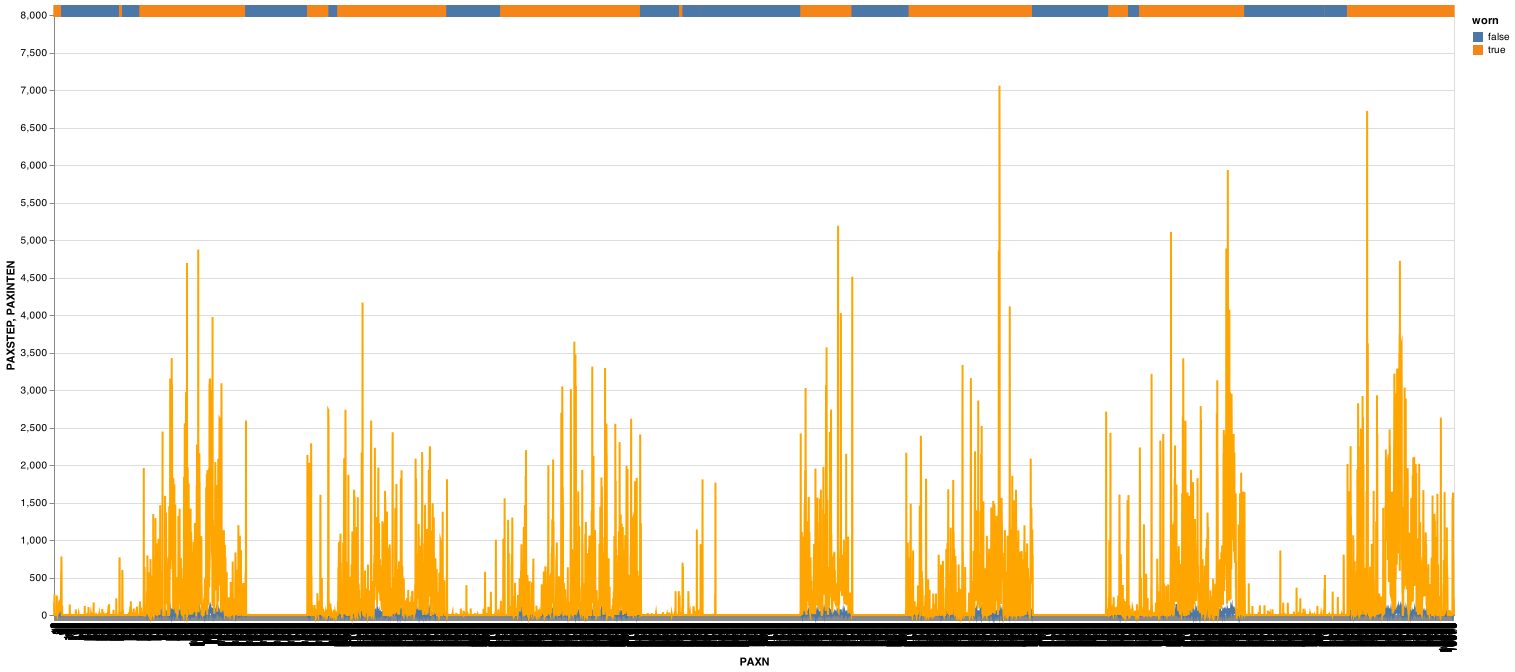

In [50]:
(
    alt.Chart(paxraw_sample)
    .mark_bar(width=1)
    .encode(x="PAXN:O", y=alt.value(-10), y2=alt.value(2), color="worn")
    + alt.Chart(paxraw_sample).mark_line().encode(x="PAXN:O", y="PAXSTEP")
    + alt.Chart(paxraw_sample).mark_line(color="orange").encode(x="PAXN:O", y="PAXINTEN")
).properties(width=1400, height=600)

In [51]:
# set the indicator to True to start
paxraw_sample.loc[:, "worn"] = True
# take the first 60 minutes
assert paxraw_sample.iloc[:60, :].shape[0] == 60
# only 2 allowed > 0, and all 60 are less than 100
if ((paxraw_sample.iloc[:60, PAXINTEN_col] > 0).sum() <= 2) and (
    (paxraw_sample.iloc[:60, PAXINTEN_col] < 100).sum() == 60
):
    paxraw_sample.iloc[:60, worn_col] = False

In [52]:
for i in range(61, paxraw_sample.shape[0]):
    assert paxraw_sample.iloc[(i - 60) : i, :].shape[0] == 60
    if ((paxraw_sample.iloc[(i - 60) : i, PAXINTEN_col] > 0).sum() <= 2) and (
        (paxraw_sample.iloc[(i - 60) : i, PAXINTEN_col] < 100).sum() == 60
    ):
        paxraw_sample.iloc[(i - 60) : i, worn_col] = False

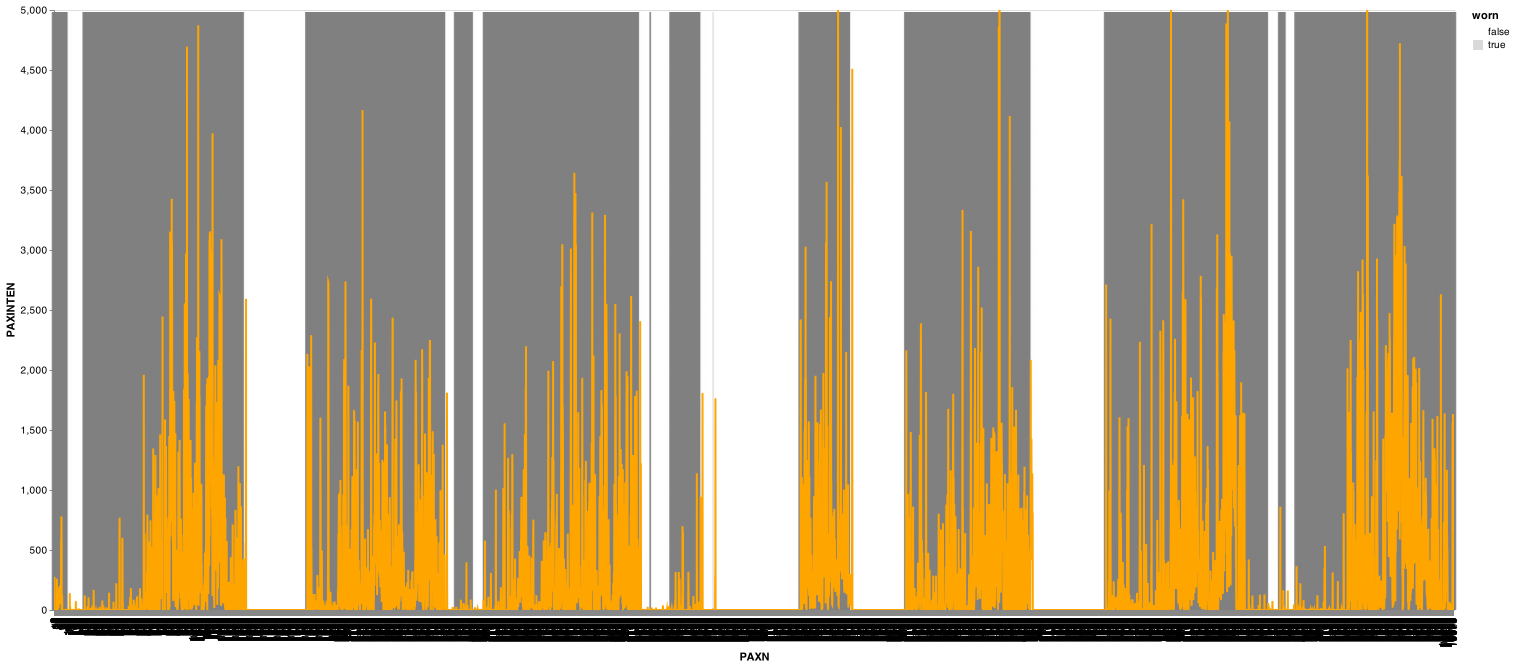

In [53]:
(
    alt.Chart(paxraw_sample)
    .mark_bar(width=5, opacity=0.3)
    .encode(
        x="PAXN:O",
        y=alt.value(600),
        y2=alt.value(2),
        color=alt.Color("worn", scale=alt.Scale(range=["white", "grey"])),
    )
    + alt.Chart(paxraw_sample)
    .mark_line(color="orange", clip=True)
    .encode(x="PAXN:O", y=alt.Y("PAXINTEN", scale=alt.Scale(domain=[0, 5000])))
).properties(width=1400, height=600)

In [54]:
# set the indicator to False to start
paxraw_sample.loc[:, "worn"] = False
# take the first 60 minutes
assert paxraw_sample.iloc[:60, :].shape[0] == 60
# only 2 allowed > 0, and all 60 are less than 100
if ((paxraw_sample.iloc[:60, PAXINTEN_col] > 0).sum() > 2) or (
    (paxraw_sample.iloc[:60, PAXINTEN_col] >= 100).sum() > 0
):
    paxraw_sample.iloc[:60, worn_col] = True

In [55]:
for i in range(61, paxraw_sample.shape[0]):
    assert paxraw_sample.iloc[(i - 60) : i, :].shape[0] == 60
    if ((paxraw_sample.iloc[(i - 60) : i, PAXINTEN_col] > 0).sum() > 2) or (
        (paxraw_sample.iloc[(i - 60) : i, PAXINTEN_col] >= 100).sum() > 0
    ):
        paxraw_sample.iloc[(i - worn_col) : i, worn_col] = True

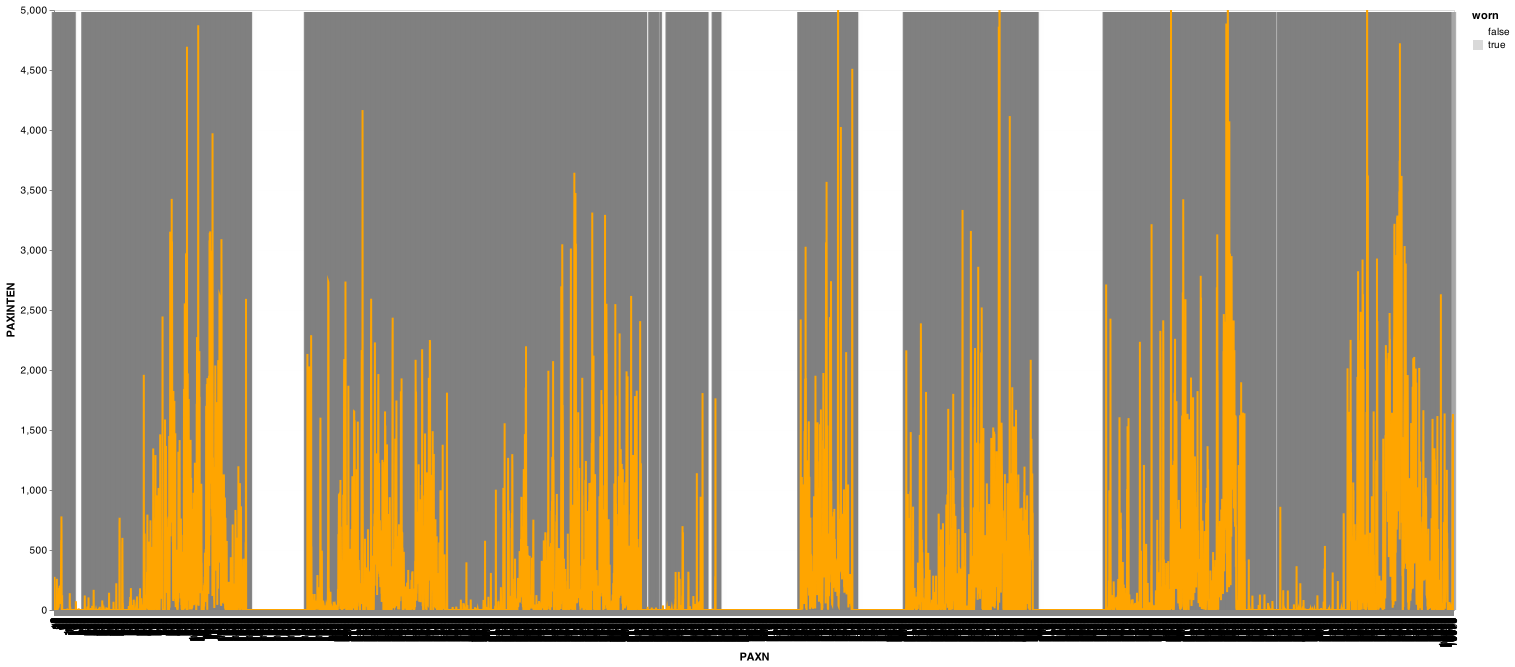

In [56]:
(
    alt.Chart(paxraw_sample)
    .mark_bar(width=5, opacity=0.3)
    .encode(
        x="PAXN:O",
        y=alt.value(600),
        y2=alt.value(2),
        color=alt.Color("worn", scale=alt.Scale(range=["white", "grey"])),
    )
    + alt.Chart(paxraw_sample)
    .mark_line(color="orange", clip=True)
    .encode(x="PAXN:O", y=alt.Y("PAXINTEN", scale=alt.Scale(domain=[0, 5000])))
).properties(width=1400, height=600)

In [57]:
worn_minutes = paxraw_sample.groupby("PAXDAY").agg({"worn": [sum], "PAXINTEN": [sum]})
worn_minutes["valid_day"] = worn_minutes["worn"]["sum"] > min_worn_hours_threshold * 60
# filter to valid days
worn_minutes = worn_minutes.loc[worn_minutes.valid_day, :]
np.mean(worn_minutes["PAXINTEN"]["sum"])

345961.4285714286

In [58]:
from utils import get_person_active_count  # noqa: E402

In [59]:
get_person_active_count(paxraw.loc[paxraw.SEQN == paxraw.SEQN.unique()[0], :])

,worn,PAXINTEN,valid_day
,sum,sum,
PAXDAY,,,
1,1276,377456,True
2,1009,308309,True
3,1273,324734,True
4,599,229846,False
5,911,304957,True
6,1065,388323,True
7,1307,488105,True


In [60]:
%%timeit
get_person_active_count(paxraw.loc[paxraw.SEQN == paxraw.SEQN.unique()[0], :])

3.5 s ± 75.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Hours:

In [61]:
3.13 * (paxraw["SEQN"].unique().shape[0]) / 60 / 60

6.481708333333333

### Test it on a slightly bigger sample

Make sure the groupby object returned makes sense before waiting 8 hours

In [62]:
person_active_counts = (
    paxraw.loc[paxraw.SEQN.isin(paxraw.SEQN.unique()[:10]), :]
    .groupby("SEQN")
    .progress_apply(get_person_active_count)
)

  0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

 20%|██████████████████████▏                                                                                        | 2/10 [00:02<00:11,  1.45s/it]

 30%|█████████████████████████████████▎                                                                             | 3/10 [00:06<00:17,  2.43s/it]

 40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:10<00:16,  2.79s/it]

 50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:13<00:15,  3.07s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:17<00:13,  3.33s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:21<00:10,  3.44s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:25<00:07,  3.55s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:29<00:03,  3.70s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.99s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.73s/it]

In [63]:
person_active_counts

worn PAXINTEN valid_day
               sum      sum          
SEQN  PAXDAY                         
31128 1       1276   377456      True
      2       1009   308309      True
      3       1273   324734      True
      4        599   229846     False
      5        911   304957      True
      6       1065   388323      True
      7       1307   488105      True
31129 1        329   125225     False
      2        879   260386      True
      3        905   281481      True
      4          8     8615     False
      5        982   274492      True
      6        929   271234      True
      7        316   118916     False
31131 1        771   282054      True
      2        885   189285      True
      3        879   202961      True
      4        914   303220      True
      5       1015   343780      True
      6        921   246466      True
      7        583   183323     False
31132 1        907   430315      True
      2        864   409685      True
      3        863   647452      True
      4        343     9231     False
      5        976   717103      True
      6        881   162362      True
      7        574   278420     False
31133 1          2      238     False
      2        766   156406      True
      3        749   237228      True
      4        983   159419      True
      5        994   289835      True
      6        914   217388      True
      7        600   148628     False
31134 1        968   268676      True
      2        137    13585     False
      3        881   454104      True
      4       1039   339230      True
      5       1051   253482      True
      6        600   218650     False
      7        815   369358      True
31137 1        747   285416      True
      2        682   236577      True
      3        531   208456     False
      4         16     3559     False
      5       1022   321241      True
      6       1111   362805      True
      7       1323   526423      True
31139 1        700    96018      True
      2        731    98912      True
      3        760   145537      True
      4        719    99049      True
      5        718   174999      True
      6        578   103628     False
      7        653   121160      True
31140 1        288   257926     False
      2        634   285108      True
      3        458   259019     False
      4        691   626162      True
      5        174    50944     False
      6          0       15     False
      7          0        3     False
31141 1        702   130114      True
      2        677   502813      True
      3        868   279641      True
      4        779   234451      True
      5        964   177635      True
      6        754   109035      True
      7        881   142933      True

In [64]:
# check that we can save and load it
# with the heirarchical indexes
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_sample_test_write.parquet"
person_active_counts.to_parquet(parquetfile)
pd.read_parquet(parquetfile).head()

worn PAXINTEN valid_day
               sum      sum          
SEQN  PAXDAY                         
31128 1       1276   377456      True
      2       1009   308309      True
      3       1273   324734      True
      4        599   229846     False
      5        911   304957      True

### Don't apply the numpy-based function to Pandas column, too slow

Because it takes almost 30 minutes.

this would take ~25 minutes
```
paxraw['worn'] = 1

for SEQN in tqdm(pd.unique(paxraw.SEQN.values)):
    paxraw.loc[paxraw.SEQN == SEQN, 'worn'] = worn_indicator(paxraw.loc[paxraw.SEQN == SEQN, 'PAXINTEN'].values)
```

```
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_met_worn.parquet"
paxraw.to_parquet(parquetfile)
```

### Skip a fully pandas-based solution entirely, it's very very slow

FWIW, the `rolling` version should take better advantage of Pandas,
but it's still too slow.

```
person_active_counts = (
    paxraw.groupby("SEQN").progress_apply(get_person_active_count).reset_index()
)
```

## Apply ~numpy-based~ numba algorithm to full dataset

~Less than 10 min.~

A few seconds.

In [65]:
from utils import bout_classifier_SEQN_long, worn_indicator_SEQN_long  # noqa: E402

In [66]:
# this should be fast
paxraw["worn"] = worn_indicator_SEQN_long(paxraw.PAXINTEN.values, paxraw.SEQN.values)

### Compare the full numpy and the numpy function applied to pandas array

It's commented out because we're not running the "numpy function applied to pandas array" version now.
They are the same

```
(paxraw['worn'] == worn).sum()
```

```
(paxraw['worn'] != worn).sum()
```

```
(paxraw['worn'] == worn).sum() == worn.shape[0]
```

```
paxraw.loc[(paxraw.worn != worn), :].head()
```

## Save parquet

In [67]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_met_worn.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2005-2006/paxraw_d_met_worn.parquet')

In [68]:
paxraw.to_parquet(parquetfile)

# Generate indicators for `bouts` of activity levels

In [69]:
paxraw["vigorous_bout"] = bout_classifier_SEQN_long(
    paxraw.PAXINTEN.values,
    paxraw.SEQN.values,
    paxraw.worn.values,
    np.zeros(paxraw.PAXINTEN.values.shape[0]),
    upper=int_cuts_endranges[5],
    lower=int_cuts_endranges[4],
    tol_upper_soft=0,
    tol_lower_soft=0,
    m=10,
    lower_soft=0,  # (int_cuts_endranges[3] + int_cuts_endranges[4])/2,
    check_already_classified=False,
)

In [70]:
paxraw["moderate_bout"] = bout_classifier_SEQN_long(
    paxraw.PAXINTEN.values,
    paxraw.SEQN.values,
    paxraw.worn.values,
    paxraw.vigorous_bout.values,
    upper=int_cuts_endranges[4],
    lower=int_cuts_endranges[3],
    tol_upper_soft=10,
    tol_lower_soft=0,
    m=10,
    lower_soft=(int_cuts_endranges[2] + int_cuts_endranges[3]) / 2,
    upper_soft=int_cuts_endranges[5],
    check_already_classified=True,
)

In [71]:
paxraw["light_bout"] = bout_classifier_SEQN_long(
    paxraw.PAXINTEN.values,
    paxraw.SEQN.values,
    paxraw.worn.values,
    np.maximum(paxraw.moderate_bout.values, paxraw.vigorous_bout.values),
    upper=int_cuts_endranges[3],
    lower=int_cuts_endranges[2],
    tol_upper_soft=10,
    tol_lower_soft=0,
    m=10,
    lower_soft=(int_cuts_endranges[1] + int_cuts_endranges[2]) / 2,
    upper_soft=int_cuts_endranges[5],
    check_already_classified=True,
)

In [72]:
paxraw["low_bout"] = bout_classifier_SEQN_long(
    paxraw.PAXINTEN.values,
    paxraw.SEQN.values,
    paxraw.worn.values,
    np.maximum(paxraw.light_bout.values, paxraw.moderate_bout.values, paxraw.vigorous_bout.values),
    upper=int_cuts_endranges[2],
    lower=int_cuts_endranges[1],
    tol_upper_soft=10,
    tol_lower_soft=0,
    m=10,
    lower_soft=(int_cuts_endranges[0] + int_cuts_endranges[1]) / 2,
    upper_soft=int_cuts_endranges[5],
    check_already_classified=True,
)

In [73]:
paxraw["sed_bout"] = bout_classifier_SEQN_long(
    paxraw.PAXINTEN.values,
    paxraw.SEQN.values,
    paxraw.worn.values,
    paxraw.low_bout.values,
    upper=int_cuts_endranges[1],
    lower=int_cuts_endranges[0],
    tol_upper_soft=0,
    tol_lower_soft=0,
    m=10,
    check_already_classified=False,
)

### Add them all to the dataframe

In [74]:
paxraw["no_bout"] = (
    (paxraw["worn"] == 1)
    & (paxraw["sed_bout"] == 0)
    & (paxraw["low_bout"] == 0)
    & (paxraw["light_bout"] == 0)
    & (paxraw["moderate_bout"] == 0)
    & (paxraw["vigorous_bout"] == 0)
) * 1

## A single column to label minute-by-minute intensity

In [75]:
paxraw["intensity"] = pd.cut(
    paxraw["PAXINTEN"].values, int_cuts_endranges, right=False, labels=range(len(labels))
)
# don't include the labels for size:
# labels=labels

In [76]:
paxraw.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,PAXSTEP,MET,worn,vigorous_bout,moderate_bout,light_bout,low_bout,sed_bout,no_bout,intensity
0,31128,1,1,1,1,0,0,166,4,1.100000,1.0,0.0,0.0,0.0,0.0,0.0,1,1
1,31128,1,1,1,2,0,1,27,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0
2,31128,1,1,1,3,0,2,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0
3,31128,1,1,1,4,0,3,276,4,1.266667,1.0,0.0,0.0,0.0,0.0,0.0,1,1
4,31128,1,1,1,5,0,4,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0


In [77]:
paxraw["METh"] = paxraw.MET / 60
paxraw["activeMETh"] = (paxraw.MET - 1) / 60

In [78]:
paxraw_sample = paxraw.loc[paxraw.SEQN == paxraw.SEQN.values[0], :].copy()
paxraw_sample.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,PAXSTEP,MET,worn,vigorous_bout,moderate_bout,light_bout,low_bout,sed_bout,no_bout,intensity,METh,activeMETh
0,31128,1,1,1,1,0,0,166,4,1.100000,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0.018333,0.001667
1,31128,1,1,1,2,0,1,27,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000
2,31128,1,1,1,3,0,2,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000
3,31128,1,1,1,4,0,3,276,4,1.266667,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0.021111,0.004444
4,31128,1,1,1,5,0,4,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000


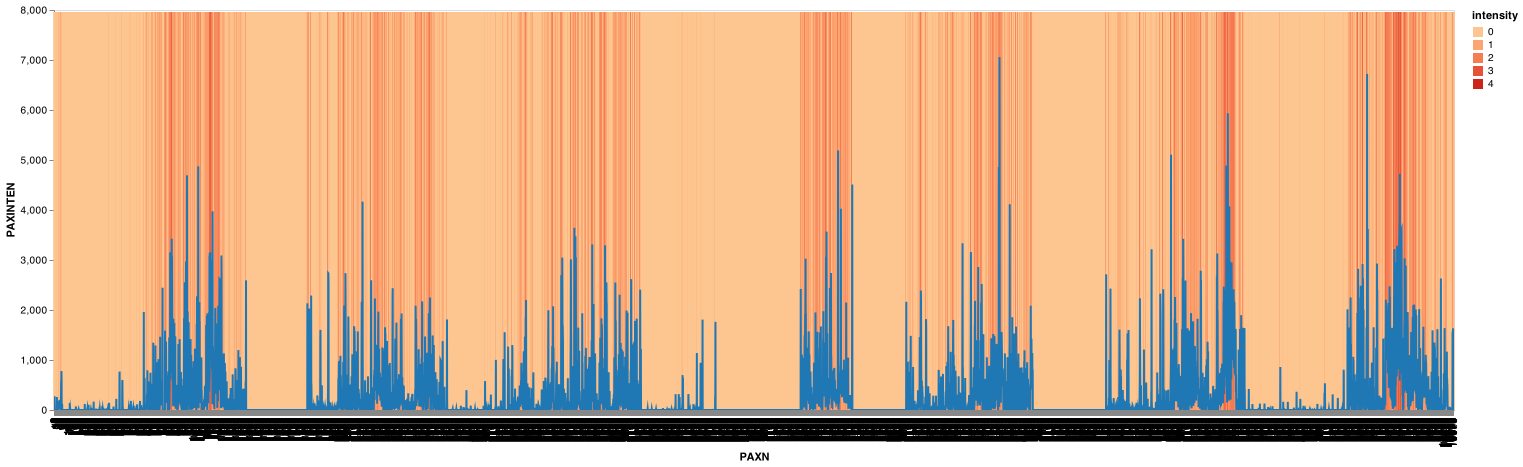

In [79]:
(
    alt.Chart(paxraw_sample)
    .mark_bar(width=1)
    .encode(
        x="PAXN:O",
        y=alt.value(400),
        y2=alt.value(2),
        color=alt.Color("intensity", scale=alt.Scale(scheme="orangered"))
        # scale=alt.Scale(range=["white", "grey"])),
    )
    + alt.Chart(paxraw_sample)
    .mark_line(color="#1f77b4", clip=True)
    .encode(x="PAXN:O", y=alt.Y("PAXINTEN", scale=alt.Scale(domain=[0, 8000])))
).properties(width=1400, height=400)

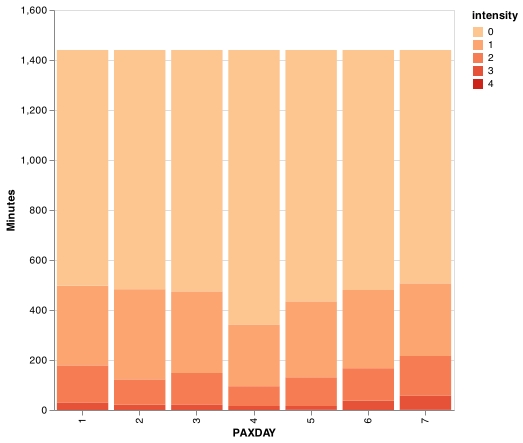

In [80]:
(
    alt.Chart(paxraw_sample)
    .mark_bar()
    .encode(
        x="PAXDAY:O",
        y=alt.Y("count()", title="Minutes"),
        color=alt.Color("intensity", scale=alt.Scale(scheme="orangered"))
        # scale=alt.Scale(range=["white", "grey"])),
    )
).properties(width=400, height=400)

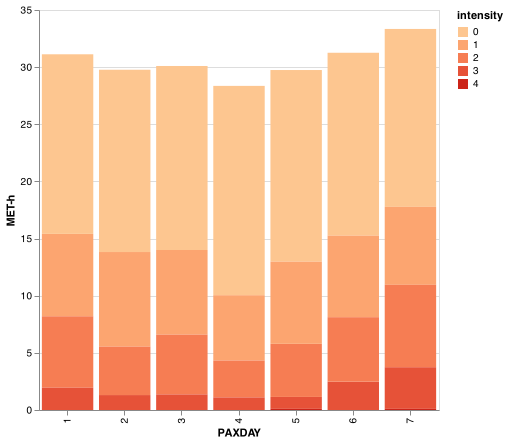

In [81]:
(
    alt.Chart(paxraw_sample)
    .mark_bar()
    .encode(
        x="PAXDAY:O",
        y=alt.Y("sum(METh)", title="MET-h"),
        color=alt.Color("intensity", scale=alt.Scale(scheme="orangered"))
        # scale=alt.Scale(range=["white", "grey"])),
    )
).properties(width=400, height=400)

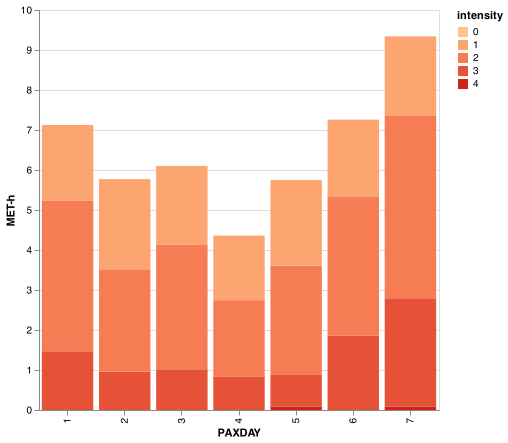

In [82]:
(
    alt.Chart(paxraw_sample)
    .mark_bar()
    .encode(
        x="PAXDAY:O",
        y=alt.Y("sum(activeMETh)", title="MET-h"),
        color=alt.Color("intensity", scale=alt.Scale(scheme="orangered"))
        # scale=alt.Scale(range=["white", "grey"])),
    )
).properties(width=400, height=400)

## Save parquet

In [83]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_met_worn_bouts.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2005-2006/paxraw_d_met_worn_bouts.parquet')

In [84]:
paxraw.to_parquet(parquetfile)
# paxraw = pd.read_parquet(parquetfile)

## Check for overlap on intensity bounts

First sum it up

In [85]:
paxraw.loc[
    :,
    [
        "worn",
        "sed_bout",
        "low_bout",
        "light_bout",
        "moderate_bout",
        "vigorous_bout",
        "no_bout",
    ],
].sum(axis=0)

worn             34326726.0
sed_bout           860091.0
low_bout          5478936.0
light_bout         641593.0
moderate_bout      220815.0
vigorous_bout      862408.0
no_bout          27125291.0
dtype: float64

From before the generalized numba function:
```
"worn             34326726.0\n",
"sed_bout         10920764.0\n",
"low_bout           604376.0\n",
"light_bout          62892.0\n",
"moderate_bout       56051.0\n",
"vigorous_bout      395787.0\n",
"no_bout          22352901.0\n",
```

In [86]:
((paxraw["worn"] == 1) & (paxraw["sed_bout"] == 0)).sum()

33466635

In [87]:
((paxraw["worn"] == 1) & (paxraw["low_bout"] == 1)).sum()

5478936

In [88]:
((paxraw["sed_bout"] == 1) & (paxraw["low_bout"] == 1)).sum()

0

In [89]:
((paxraw["sed_bout"] == 1) & (paxraw["light_bout"] == 1)).sum()

0

In [90]:
((paxraw["sed_bout"] == 1) & (paxraw["moderate_bout"] == 1)).sum()

0

In [91]:
((paxraw["sed_bout"] == 1) & (paxraw["vigorous_bout"] == 1)).sum()

0

# Get valid days and other filters

## Worn minutes by person-day to compute `valid_day`

In [92]:
# sum minutes of wear and activity counts per day
worn_minutes = paxraw.groupby(["SEQN", "PAXDAY"]).agg({"worn": [np.sum]})

worn_minutes.columns = flatten_columns(worn_minutes.columns.values)

In [93]:
# compute valid days
worn_minutes["valid_day"] = (
    worn_minutes["worn"]["sum"] > (min_worn_hours_threshold * MINUTES_PER_HOUR)
) * 1

In [94]:
worn_minutes.head(15)

worn valid_day
                 sum          
SEQN  PAXDAY                  
31128 1       1276.0         1
      2       1009.0         1
      3       1273.0         1
      4        599.0         0
      5        911.0         1
      6       1065.0         1
      7       1307.0         1
31129 1        329.0         0
      2        879.0         1
      3        904.0         1
      4          8.0         0
      5        982.0         1
      6        929.0         1
      7        316.0         0
31131 1        771.0         1

In [95]:
worn_minutes.columns = flatten_columns(worn_minutes.columns.values)

In [96]:
worn_minutes.head(15)

worn_sum  valid_day
SEQN  PAXDAY                     
31128 1         1276.0          1
      2         1009.0          1
      3         1273.0          1
      4          599.0          0
      5          911.0          1
      6         1065.0          1
      7         1307.0          1
31129 1          329.0          0
      2          879.0          1
      3          904.0          1
      4            8.0          0
      5          982.0          1
      6          929.0          1
      7          316.0          0
31131 1          771.0          1

## Other indicators at person-day level that can be used to filter

In [97]:
agg_columns = ["PAXINTEN", "max_intensity", "out_of_calibration", "unreliable"]

In [98]:
paxraw["max_intensity"] = (paxraw.PAXINTEN == 32767) * 1
paxraw["out_of_calibration"] = (paxraw.PAXCAL == 2) * 1
paxraw["unreliable"] = (paxraw.PAXSTAT == 2) * 1

In [99]:
if "PAXSTEP" not in paxraw.columns:
    paxraw["PAXSTEP"] = 0
    paxraw["zero_steps_with_intensity"] = 0
else:
    paxraw["zero_steps_with_intensity"] = ((paxraw.PAXINTEN > 250) & (paxraw.PAXSTEP == 0)) * 1

In [100]:
paxraw["too_many_steps"] = (paxraw.PAXSTEP > 200) * 1

In [101]:
# add a variable for steps_filtered, summing steps only if we have intensity over 500
paxraw["steps_filtered_500"] = 0
paxraw.loc[paxraw.PAXINTEN >= 500, "steps_filtered_500"] = paxraw.PAXSTEP
paxraw["steps_filtered_300"] = 0
paxraw.loc[paxraw.PAXINTEN >= 300, "steps_filtered_300"] = paxraw.PAXSTEP

In [102]:
agg_columns += [
    "zero_steps_with_intensity",
    "too_many_steps",
    "steps_filtered_500",
    "steps_filtered_300",
]

In [103]:
tudor2009_filters = (
    paxraw.groupby(["SEQN", "PAXDAY"])
    .agg({col: [np.sum, "last"] for col in agg_columns})
    .reset_index()
)
tudor2009_filters.columns = flatten_columns(tudor2009_filters.columns.values)

In [104]:
tudor2009_filters.head(15)

,SEQN,PAXDAY,PAXINTEN_sum,PAXINTEN_last,max_intensity_sum,max_intensity_last,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,zero_steps_with_intensity_sum,zero_steps_with_intensity_last,too_many_steps_sum,too_many_steps_last,steps_filtered_500_sum,steps_filtered_500_last,steps_filtered_300_sum,steps_filtered_300_last
0,31128,1,377456,0,0,0,0,0,0,0,0,0,0,0,9414,0,10819,0
1,31128,2,308309,0,0,0,0,0,0,0,0,0,0,0,7643,0,9218,0
2,31128,3,324734,0,0,0,0,0,0,0,0,0,0,0,7740,0,9067,0
3,31128,4,229846,0,0,0,0,0,0,0,0,0,0,0,4419,0,5600,0
4,31128,5,304957,0,0,0,0,0,0,0,0,0,0,0,8001,0,9707,0
5,31128,6,388323,0,0,0,0,0,0,0,0,0,0,0,11005,0,12841,0
6,31128,7,488105,0,0,0,0,0,0,0,0,0,0,0,13191,0,14263,0
7,31129,1,125225,0,0,0,0,0,0,0,0,0,0,0,2720,0,3223,0
8,31129,2,260386,0,0,0,0,0,0,0,0,0,0,0,6697,0,7707,0
9,31129,3,281481,0,0,0,0,0,0,0,0,0,0,0,7116,0,7968,0


### Join all person-day level indicators

In [105]:
d_people_days = tudor2009_filters.merge(worn_minutes, how="inner", on=["SEQN", "PAXDAY"])

In [106]:
d_people_days.head(15)

,SEQN,PAXDAY,PAXINTEN_sum,PAXINTEN_last,max_intensity_sum,max_intensity_last,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,zero_steps_with_intensity_sum,zero_steps_with_intensity_last,too_many_steps_sum,too_many_steps_last,steps_filtered_500_sum,steps_filtered_500_last,steps_filtered_300_sum,steps_filtered_300_last,worn_sum,valid_day
0,31128,1,377456,0,0,0,0,0,0,0,0,0,0,0,9414,0,10819,0,1276.0,1
1,31128,2,308309,0,0,0,0,0,0,0,0,0,0,0,7643,0,9218,0,1009.0,1
2,31128,3,324734,0,0,0,0,0,0,0,0,0,0,0,7740,0,9067,0,1273.0,1
3,31128,4,229846,0,0,0,0,0,0,0,0,0,0,0,4419,0,5600,0,599.0,0
4,31128,5,304957,0,0,0,0,0,0,0,0,0,0,0,8001,0,9707,0,911.0,1
5,31128,6,388323,0,0,0,0,0,0,0,0,0,0,0,11005,0,12841,0,1065.0,1
6,31128,7,488105,0,0,0,0,0,0,0,0,0,0,0,13191,0,14263,0,1307.0,1
7,31129,1,125225,0,0,0,0,0,0,0,0,0,0,0,2720,0,3223,0,329.0,0
8,31129,2,260386,0,0,0,0,0,0,0,0,0,0,0,6697,0,7707,0,879.0,1
9,31129,3,281481,0,0,0,0,0,0,0,0,0,0,0,7116,0,7968,0,904.0,1


In [107]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_people_days.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2005-2006/paxraw_d_people_days.parquet')

In [108]:
d_people_days.to_parquet(parquetfile)

## Sum up to person level

In [109]:
d_people = d_people_days.groupby("SEQN").agg(
    {
        "zero_steps_with_intensity_sum": np.sum,
        "too_many_steps_sum": np.sum,
        "max_intensity_sum": np.sum,
        "out_of_calibration_sum": np.sum,
        "out_of_calibration_last": "last",
        "unreliable_sum": np.sum,
        "unreliable_last": "last",
        "steps_filtered_500_sum": np.mean,
        "steps_filtered_300_sum": np.mean,
        "valid_day": np.sum,
        "PAXINTEN_sum": np.mean,
    }
)

In [110]:
d_people.head(15)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
31128,0,0,0,0,0,0,0,8773.285714,10216.428571,6,345961.428571
31129,0,0,0,0,0,0,0,4555.142857,5213.428571,4,191478.428571
31131,0,0,0,0,0,0,0,6346.857143,7688.285714,6,250155.571429
31132,0,0,0,0,0,0,0,9984.857143,10688.571429,5,379224.000000
31133,0,0,0,0,0,0,0,3301.428571,3956.285714,5,172734.571429
31134,0,0,0,0,0,0,0,6504.428571,7244.571429,5,273869.285714
31137,0,0,0,0,0,0,0,7412.428571,9072.142857,5,277782.428571
31139,0,0,0,0,0,0,0,1543.571429,2102.714286,6,119900.428571
31140,0,0,0,0,0,0,0,4056.142857,4457.857143,2,211311.000000


In [111]:
d_people.shape

(7455, 11)

In [112]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_people.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2005-2006/paxraw_d_people.parquet')

In [113]:
d_people.to_parquet(parquetfile)

## Use the indicators to filter to people with reliable data

In [114]:
d_reliable = d_people.loc[
    (d_people.zero_steps_with_intensity_sum <= 10)
    & (d_people.too_many_steps_sum <= 10)
    & (d_people.max_intensity_sum <= 10)
    & (~d_people.out_of_calibration_last)
    & (d_people.unreliable_sum <= 10)
    & (d_people.steps_filtered_500_sum <= 200000),
    :,
]
d_reliable.head(15)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
31128,0,0,0,0,0,0,0,8773.285714,10216.428571,6,345961.428571
31129,0,0,0,0,0,0,0,4555.142857,5213.428571,4,191478.428571
31131,0,0,0,0,0,0,0,6346.857143,7688.285714,6,250155.571429
31132,0,0,0,0,0,0,0,9984.857143,10688.571429,5,379224.000000
31133,0,0,0,0,0,0,0,3301.428571,3956.285714,5,172734.571429
31134,0,0,0,0,0,0,0,6504.428571,7244.571429,5,273869.285714
31137,0,0,0,0,0,0,0,7412.428571,9072.142857,5,277782.428571
31139,0,0,0,0,0,0,0,1543.571429,2102.714286,6,119900.428571
31140,0,0,0,0,0,0,0,4056.142857,4457.857143,2,211311.000000


In [115]:
d_reliable.shape

(6863, 11)

In [116]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_reliable_people.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2005-2006/paxraw_d_reliable_people.parquet')

In [117]:
d_reliable.to_parquet(parquetfile)

## Use filtered people to select rows from full data

In [118]:
paxraw_reliable = paxraw.merge(
    worn_minutes.loc[worn_minutes.valid_day == 1, :], on=["SEQN", "PAXDAY"]
).merge(d_reliable.loc[:, []], how="inner", on="SEQN")
paxraw_reliable.head(10)

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,PAXSTEP,MET,worn,vigorous_bout,moderate_bout,light_bout,low_bout,sed_bout,no_bout,intensity,METh,activeMETh,max_intensity,out_of_calibration,unreliable,zero_steps_with_intensity,too_many_steps,steps_filtered_500,steps_filtered_300,worn_sum,valid_day
0,31128,1,1,1,1,0,0,166,4,1.100000,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0.018333,0.001667,0,0,0,0,0,0,0,1276.0,1
1,31128,1,1,1,2,0,1,27,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000,0,0,0,0,0,0,0,1276.0,1
2,31128,1,1,1,3,0,2,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000,0,0,0,0,0,0,0,1276.0,1
3,31128,1,1,1,4,0,3,276,4,1.266667,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0.021111,0.004444,0,0,0,0,0,0,0,1276.0,1
4,31128,1,1,1,5,0,4,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000,0,0,0,0,0,0,0,1276.0,1
5,31128,1,1,1,6,0,5,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000,0,0,0,0,0,0,0,1276.0,1
6,31128,1,1,1,7,0,6,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000,0,0,0,0,0,0,0,1276.0,1
7,31128,1,1,1,8,0,7,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000,0,0,0,0,0,0,0,1276.0,1
8,31128,1,1,1,9,0,8,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000,0,0,0,0,0,0,0,1276.0,1
9,31128,1,1,1,10,0,9,0,0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.000000,0,0,0,0,0,0,0,1276.0,1


In [119]:
paxraw_reliable.shape

(46186041, 29)

In [120]:
paxraw_reliable.shape

(46186041, 29)

## Save parquet

In [121]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_met_worn_bouts_reliable.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2005-2006/paxraw_d_met_worn_bouts_reliable.parquet')

In [122]:
paxraw_reliable.to_parquet(parquetfile)

# Look at intensity distribution and METh thresholds

### Group by intensity to sum MET-h levels across days

In [123]:
groupedMETh = (
    paxraw_sample.groupby(["intensity", "PAXDAY"])
    .agg({"activeMETh": np.sum})
    .groupby(["intensity"])
    .agg({"activeMETh": np.mean})
)
groupedMETh

,activeMETh
intensity,
0,0.000000
1,1.969329
2,3.158906
3,1.377102
4,0.024444


In [124]:
groupedMETh.sum()

activeMETh    6.52978
dtype: float64

This is the same as just taking the mean of the sum (without grouping by intensity in the middle):

In [125]:
paxraw_sample.groupby(["PAXDAY"]).agg({"activeMETh": np.sum}).mean()

activeMETh    6.52978
dtype: float64

In [126]:
paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"]).agg({"activeMETh": np.sum}).head()

activeMETh
SEQN  intensity PAXDAY            
31128 0         1              0.0
                2              0.0
                3              0.0
                4              0.0
                5              0.0

In [127]:
paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"]).agg({"activeMETh": np.sum}).groupby(
    ["SEQN", "intensity"]
).agg({"activeMETh": np.mean}).head()

activeMETh
SEQN  intensity            
31128 0            0.000000
      1            1.738496
      2            2.886298
      3            1.257598
      4            0.024444

In [128]:
minutes_at_intensity = (
    paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"])
    .agg({"activeMETh": "count"})
    .groupby(["SEQN", "intensity"])
    .agg({"activeMETh": np.mean})
    .groupby(["intensity"])
    .agg({"activeMETh": np.mean})
)
minutes_at_intensity

,activeMETh
intensity,
0,763.929099
1,182.825856
2,66.517585
3,21.937875
4,1.396948


In [129]:
METh_at_intensity = (
    paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"])
    .agg({"activeMETh": np.sum})
    .groupby(["SEQN", "intensity"])
    .agg({"activeMETh": np.mean})
    .groupby(["intensity"])
    .agg({"activeMETh": np.mean})
)
METh_at_intensity

,activeMETh
intensity,
0,0.000000
1,1.066732
2,1.711808
3,1.147303
4,0.127616


In [130]:
minutes_METh = minutes_at_intensity.rename(columns={"activeMETh": "minutes"}).merge(
    METh_at_intensity, how="inner", on="intensity"
)
minutes_METh

,minutes,activeMETh
intensity,,
0,763.929099,0.000000
1,182.825856,1.066732
2,66.517585,1.711808
3,21.937875,1.147303
4,1.396948,0.127616


In [131]:
minutes_METh_stack = (
    pd.concat(
        [
            minutes_at_intensity.assign(metric="minutes"),
            METh_at_intensity.assign(metric="MET", activeMETh=lambda d: d.activeMETh * 60),
        ]
    )
    .reset_index()
    .merge(
        pd.DataFrame({"label": labels, "intensity": range(5)}),
        how="left",
        on="intensity",
    )
)
minutes_METh_stack

,intensity,activeMETh,metric,label
0,0,763.929099,minutes,Sedentary
1,1,182.825856,minutes,Low
2,2,66.517585,minutes,Light
3,3,21.937875,minutes,Moderate
4,4,1.396948,minutes,Vigorous
5,0,0.000000,MET,Sedentary
6,1,64.003916,MET,Low
7,2,102.708509,MET,Light
8,3,68.838166,MET,Moderate
9,4,7.656979,MET,Vigorous


### MET Minutes vs Minutes by intensity level

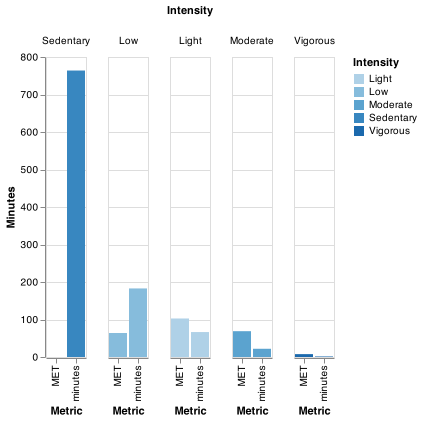

In [132]:
alt.Chart(minutes_METh_stack).mark_bar().encode(
    x=alt.X("metric:N", title="Metric"),
    y=alt.Y("activeMETh:Q", title="Minutes"),
    color=alt.Color("label:O", title="Intensity"),
    column=alt.Column(
        "label:O", title="Intensity", sort=alt.SortField("intensity", order="ascending")
    ),
)

Skip sedentary - no METs

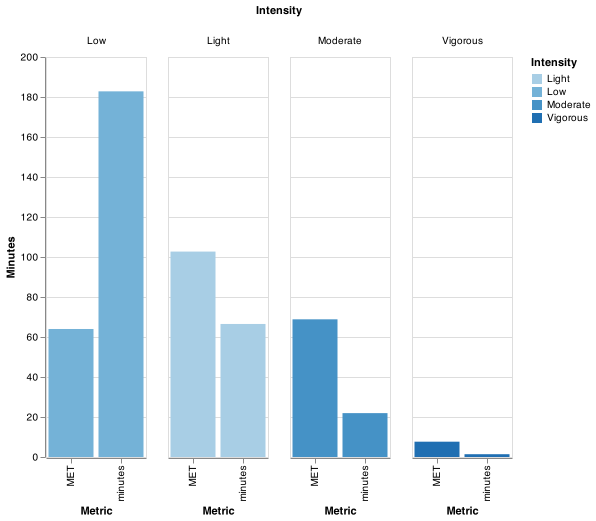

In [133]:
alt.Chart(minutes_METh_stack.loc[minutes_METh_stack.intensity > 0, :]).mark_bar().encode(
    x=alt.X("metric:N", title="Metric"),
    y=alt.Y("activeMETh:Q", title="Minutes"),
    color=alt.Color("label:O", title="Intensity"),
    column=alt.Column(
        "label:O", title="Intensity", sort=alt.SortField("intensity", order="ascending")
    ),
).properties(width=100, height=400)

## Distribution of weekly METh

In [134]:
(
    paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"])
    .agg({"activeMETh": np.sum})
    .groupby(["SEQN", "intensity"])
    .agg({"activeMETh": np.mean})
    .groupby(["SEQN"])
    .agg({"activeMETh": np.sum})
).mean() * 7

activeMETh    28.374216
dtype: float64

In [135]:
METh = (
    paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"])
    .agg({"activeMETh": np.sum})
    .groupby(["SEQN", "intensity"])
    .agg({"activeMETh": np.mean})
    .groupby(["SEQN"])
    .agg({"activeMETh": np.sum})
).assign(weeklyMETh=lambda d: d.activeMETh * 7)
METh

,activeMETh,weeklyMETh
SEQN,,
31128,5.906835,41.347847
31129,2.800030,19.600213
31131,4.020895,28.146262
31132,5.833550,40.834849
31133,2.700036,18.900250
...,...,...
41468,2.945727,20.620088
41471,7.180111,50.260778
41472,4.825957,33.781700


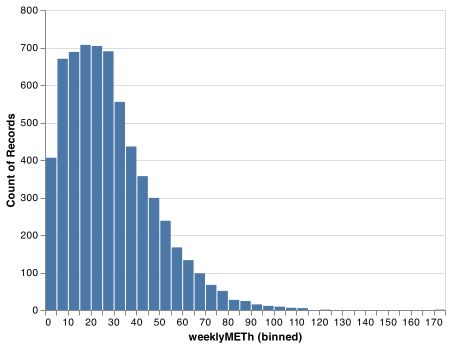

In [136]:
alt.Chart(METh).mark_bar().encode(
    alt.X("weeklyMETh:Q", bin=alt.BinParams(maxbins=35)),
    y="count()",
)

## Look at different METh thresholds and % of people getting rewards (and total utilization)

In [137]:
cut, cuts = pd.qcut(METh.weeklyMETh, 10, retbins=True)
cut

SEQN
31128    (35.438, 43.172]
31129     (16.13, 20.589]
31131    (25.071, 29.654]
31132    (35.438, 43.172]
31133     (16.13, 20.589]
               ...       
41468    (20.589, 25.071]
41471    (43.172, 54.424]
41472    (29.654, 35.438]
41473     (11.381, 16.13]
41474    (29.654, 35.438]
Name: weeklyMETh, Length: 6365, dtype: category
Categories (10, interval[float64, right]): [(0.027899999999999998, 6.676] < (6.676, 11.381] < (11.381, 16.13] < (16.13, 20.589] ... (29.654, 35.438] < (35.438, 43.172] < (43.172, 54.424] < (54.424, 173.429]]

In [138]:
cuts

array([2.88798701e-02, 6.67554617e+00, 1.13810837e+01, 1.61297168e+01,
       2.05892696e+01, 2.50709474e+01, 2.96544436e+01, 3.54380840e+01,
       4.31720367e+01, 5.44241588e+01, 1.73429322e+02])

In [139]:
cut.cat.categories

IntervalIndex([(0.027899999999999998, 6.676], (6.676, 11.381], (11.381, 16.13], (16.13, 20.589], (20.589, 25.071], (25.071, 29.654], (29.654, 35.438], (35.438, 43.172], (43.172, 54.424], (54.424, 173.429]], dtype='interval[float64, right]')

In [140]:
utilization = pd.DataFrame(
    {
        "target": np.linspace(cuts[1], cuts[-2], num=50),
        "Total Utilization": [
            np.minimum(METh.weeklyMETh.values / x, 1).mean()
            for x in np.linspace(cuts[1], cuts[-2], num=50)
        ],
        "Max Rewards": [
            (METh.weeklyMETh.values / x >= 1).sum() / METh.shape[0]
            for x in np.linspace(cuts[1], cuts[-2], num=50)
        ],
    }
)

In [141]:
utilization.head()

,target,Total Utilization,Max Rewards
0,6.675546,0.960492,0.899921
1,7.650008,0.951684,0.882011
2,8.624469,0.942631,0.861273
3,9.598931,0.933258,0.840063
4,10.573392,0.923710,0.819482


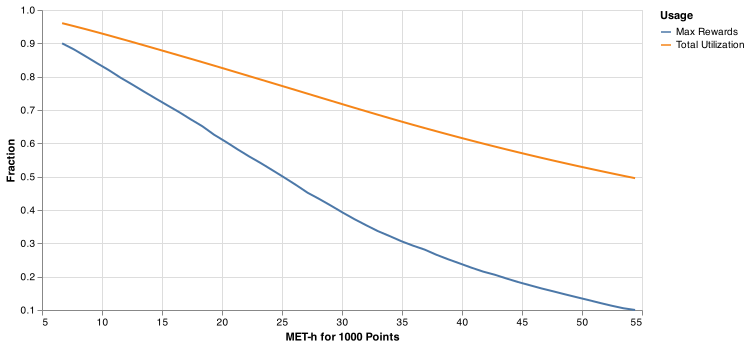

In [142]:
alt.Chart(utilization).mark_line().transform_fold(
    fold=["Total Utilization", "Max Rewards"], as_=["variable", "value"]
).encode(
    alt.X("target:Q", title="MET-h for 1000 Points"),
    alt.Y("value:Q", title="Fraction", scale=alt.Scale(zero=False)),
    alt.Color("variable:N", title="Usage"),
).properties(
    width=600
)

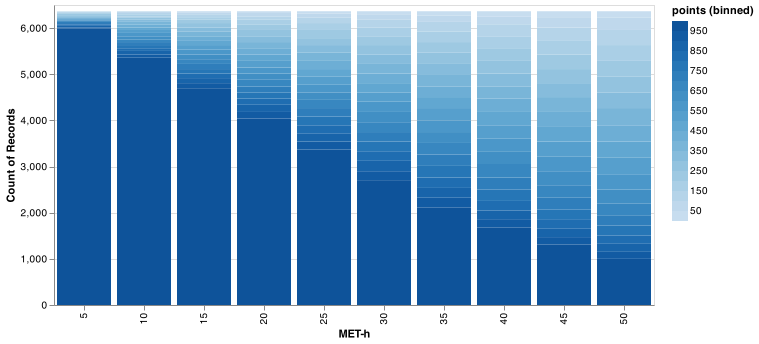

In [143]:
alt.Chart(
    pd.concat(
        [
            pd.DataFrame({"points": np.minimum(METh.weeklyMETh.values / x, 1) * 1000, "MET-h": x})
            for x in np.arange(5, 55, 5)
        ]
    )
).mark_bar().encode(
    alt.Color("points:Q", bin=alt.BinParams(maxbins=20)),
    alt.Y("count()"),
    alt.X("MET-h:O"),
).properties(
    width=600
)

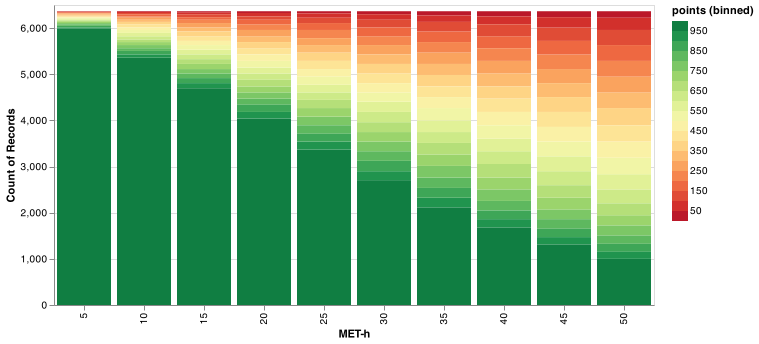

In [144]:
alt.Chart(
    pd.concat(
        [
            pd.DataFrame({"points": np.minimum(METh.weeklyMETh.values / x, 1) * 1000, "MET-h": x})
            for x in np.arange(5, 55, 5)
        ]
    )
).mark_bar().encode(
    alt.Color(
        "points:Q",
        bin=alt.BinParams(maxbins=20),
        scale=alt.Scale(scheme="redyellowgreen"),
    ),
    alt.Y("count()"),
    alt.X("MET-h:O"),
).properties(
    width=600
)

## Ena's chart of points by intensity for different amounts of points earned

In [145]:
all_intensities = pd.DataFrame(
    {
        "SEQN": np.repeat(pd.unique(paxraw_reliable.SEQN.values), 5),
        "intensity": np.tile(np.arange(5), pd.unique(paxraw_reliable.SEQN.values).shape[0]),
    }
)
all_intensities.head(11)

,SEQN,intensity
0,31128,0
1,31128,1
2,31128,2
3,31128,3
4,31128,4
5,31129,0
6,31129,1
7,31129,2
8,31129,3
9,31129,4


In [146]:
points_by_intensity = (
    paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"], dropna=False)
    .agg({"activeMETh": np.sum, "worn": np.sum})
    .groupby(["SEQN", "intensity"], dropna=False)
    .agg({"activeMETh": np.mean, "worn": np.mean})
    # fill in blank intensities
    .merge(all_intensities, how="outer", on=list(all_intensities.columns))
    .fillna(0)
    # calc points
    .assign(weeklyMETh=lambda d: d.activeMETh * 7, points=lambda d: d.weeklyMETh / 25 * 1000)
    .rename(columns={"worn": "dailyMinutes"})
    .reset_index()
)
points_by_intensity.head()

,index,SEQN,intensity,activeMETh,dailyMinutes,weeklyMETh,points
0,0,31128,0,0.000000,566.714286,0.000000,0.000000
1,1,31128,1,1.738496,273.142857,12.169470,486.778788
2,2,31128,2,2.886298,111.571429,20.204087,808.163492
3,3,31128,3,1.257598,25.571429,8.803185,352.127419
4,4,31128,4,0.024444,0.285714,0.171105,6.844185


In [147]:
points_by_person = (
    points_by_intensity.groupby("SEQN")
    .agg({"points": np.sum})
    .assign(
        points_capped=lambda d: np.minimum(d.points, 1000),
        point_bin=lambda d: pd.cut(d.points_capped, np.arange(11) * 100, right=True),
    )
)
points_by_person

,points,points_capped,point_bin
SEQN,,,
31128,1653.913884,1000.000000,"(900, 1000]"
31129,784.008504,784.008504,"(700, 800]"
31131,1125.850467,1000.000000,"(900, 1000]"
31132,1633.393954,1000.000000,"(900, 1000]"
31133,756.009998,756.009998,"(700, 800]"
...,...,...,...
41468,824.803500,824.803500,"(800, 900]"
41471,2010.431113,1000.000000,"(900, 1000]"
41472,1351.267992,1000.000000,"(900, 1000]"


In [148]:
point_thresholds_by_intensity = (
    points_by_intensity.merge(points_by_person, how="left", on="SEQN")
    .assign(
        points_relative=lambda d: d.points_x / d.points_y,
        dailyMinutesCapped=lambda d: d.dailyMinutes * d.points_capped / d.points_y,
    )
    .groupby(["point_bin", "intensity"], dropna=False)
    .agg(
        {
            "points_relative": np.mean,
            "points_capped": np.mean,
            "dailyMinutesCapped": np.mean,
        }
    )
    .assign(
        points=lambda d: d.points_relative * d.points_capped,
    )
    .reset_index()
    .assign(point_bin=lambda d: d.point_bin.astype("str"))
    .merge(pd.DataFrame({"label": labels, "intensity": np.arange(5)}), how="left", on="intensity")
)
point_thresholds_by_intensity

,point_bin,intensity,points_relative,points_capped,dailyMinutesCapped,points,label
0,"(0, 100]",0,0.000000,57.634948,169.039514,0.000000,Sedentary
1,"(0, 100]",1,0.526927,57.634948,27.462006,30.369437,Low
2,"(0, 100]",2,0.342279,57.634948,2.873354,19.727212,Light
3,"(0, 100]",3,0.126602,57.634948,0.491388,7.296681,Moderate
4,"(0, 100]",4,0.004192,57.634948,0.009119,0.241617,Vigorous
5,"(100, 200]",0,0.000000,153.820810,219.302965,0.000000,Sedentary
6,"(100, 200]",1,0.476642,153.820810,57.035040,73.317420,Low
7,"(100, 200]",2,0.369145,153.820810,8.267925,56.782143,Light
8,"(100, 200]",3,0.147733,153.820810,1.657682,22.724409,Moderate
9,"(100, 200]",4,0.006481,153.820810,0.041509,0.996838,Vigorous


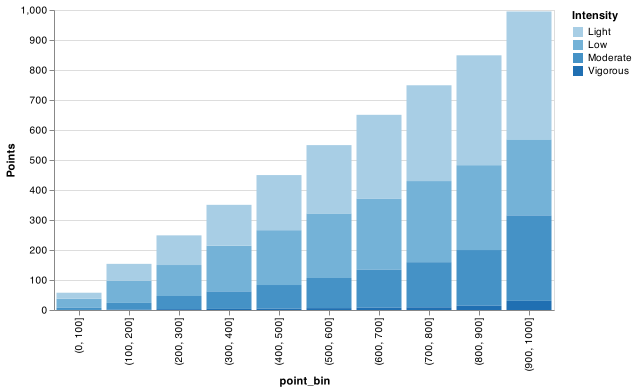

In [149]:
alt.Chart(
    point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :]
).mark_bar().encode(
    alt.X("point_bin:O"),
    alt.Y("points:Q", title="Points"),
    alt.Color("label:O", title="Intensity", sort=alt.SortField("label", order="ascending")),
).properties(
    width=500
)

### Stack the bar chart

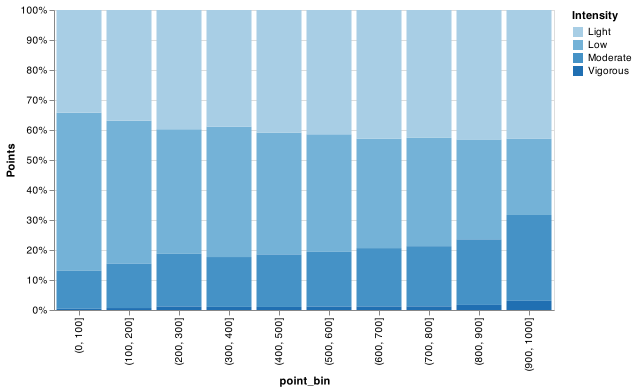

In [150]:
alt.Chart(
    point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :]
).mark_bar().encode(
    alt.X("point_bin:O"),
    alt.Y("points:Q", title="Points", stack="normalize"),
    alt.Color("label:O", title="Intensity", sort=alt.SortField("label", order="ascending")),
).properties(
    width=500
)

### Convert this to daily times in zones

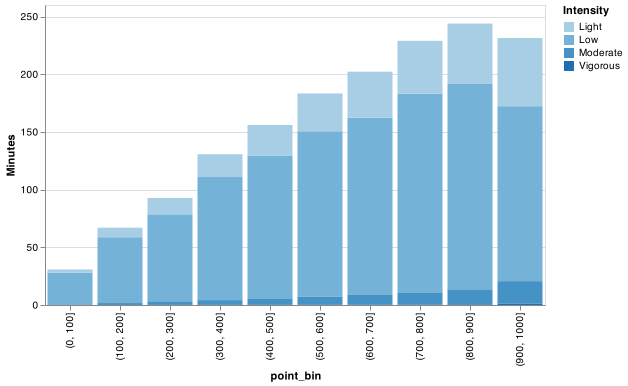

In [151]:
alt.Chart(
    point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :]
).mark_bar().encode(
    alt.X("point_bin:O"),
    alt.Y("dailyMinutesCapped:Q", title="Minutes"),
    alt.Detail("label:O", title="Intensity"),
    alt.Color("label:O", title="Intensity", sort=alt.SortField("label", order="ascending")),
    tooltip=["label", "dailyMinutesCapped", "point_bin", "points"],
).properties(
    width=500
)

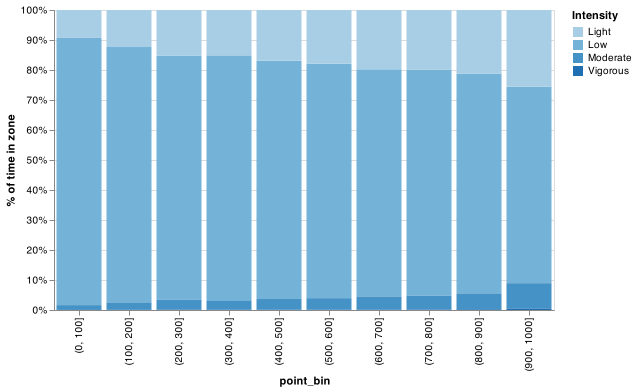

In [152]:
alt.Chart(
    point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :]
).mark_bar().encode(
    alt.X("point_bin:O"),
    alt.Y("dailyMinutesCapped:Q", title="% of time in zone", stack="normalize"),
    alt.Detail("label:O", title="Intensity"),
    alt.Color("label:O", title="Intensity", sort=alt.SortField("label", order="ascending")),
    tooltip=["label", "dailyMinutesCapped", "point_bin", "points"],
).properties(
    width=500
)

In [153]:
point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :].pivot(
    index="point_bin", columns="label", values="dailyMinutesCapped"
)

label,Light,Low,Moderate,Vigorous
point_bin,,,,
"(0, 100]",2.873354,27.462006,0.491388,0.009119
"(100, 200]",8.267925,57.035040,1.657682,0.041509
"(200, 300]",14.190913,75.412407,3.079511,0.115334
"(300, 400]",19.742191,106.703457,4.056643,0.146606
"(400, 500]",26.389838,123.906289,5.533944,0.176177
"(500, 600]",32.789234,143.342857,6.975983,0.244720
"(600, 700]",39.966210,153.113772,8.834046,0.299401
"(700, 800]",45.692072,172.365377,10.534661,0.353121
"(800, 900]",51.874594,178.532873,12.932630,0.571834


In [154]:
point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :].pivot(
    index="point_bin", columns="label", values="dailyMinutesCapped"
).assign(Moderate_and_Vigorous=lambda d: d.Moderate + d.Vigorous * 2).rename(
    columns={"Moderate_and_Vigorous": "Moderate_and_Vigorous".replace("_", " ")}
).loc[
    :, ["Low", "Light", "Moderate and Vigorous"]
].astype(
    "int"
)

label,Low,Light,Moderate and Vigorous
point_bin,,,
"(0, 100]",27,2,0
"(100, 200]",57,8,1
"(200, 300]",75,14,3
"(300, 400]",106,19,4
"(400, 500]",123,26,5
"(500, 600]",143,32,7
"(600, 700]",153,39,9
"(700, 800]",172,45,11
"(800, 900]",178,51,14


In [155]:
point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :].pivot(
    index="point_bin", columns="label", values="dailyMinutesCapped"
).assign(
    Moderate_and_Vigorous=lambda d: d.Moderate + d.Vigorous * 2,
    Light=lambda d: d.Low * 0.5 + d.Light,
).rename(
    columns={"Moderate_and_Vigorous": "Moderate_and_Vigorous".replace("_", " ")}
).loc[
    :, ["Light", "Moderate and Vigorous"]
].astype(
    "int"
)

label,Light,Moderate and Vigorous
point_bin,,
"(0, 100]",16,0
"(100, 200]",36,1
"(200, 300]",51,3
"(300, 400]",73,4
"(400, 500]",88,5
"(500, 600]",104,7
"(600, 700]",116,9
"(700, 800]",131,11
"(800, 900]",141,14


# Additional plots

## Aggregate to daily

In [156]:
by_day = (
    paxraw.groupby(["SEQN", "PAXDAY"])
    .agg({"PAXSTEP": [sum], "PAXINTEN": [sum, np.mean, max]})
    .reset_index()
)
by_day.head()

SEQN PAXDAY PAXSTEP PAXINTEN                  
                    sum      sum        mean   max
0  31128      1   12668   377456  262.122222  4873
1  31128      2   11920   308309  214.103472  4166
2  31128      3   11169   324734  225.509722  3644
3  31128      4    6824   229846  159.615278  5190
4  31128      5   11342   304957  211.775694  7058

In [157]:
by_day.shape

(52056, 6)

In [158]:
# by_day.columns = by_day.columns.get_level_values(0)
by_day.columns = flatten_columns(by_day.columns)

In [159]:
by_day.loc[by_day.SEQN == 31128.0, :]

,SEQN,PAXDAY,PAXSTEP_sum,PAXINTEN_sum,PAXINTEN_mean,PAXINTEN_max
0,31128,1,12668,377456,262.122222,4873
1,31128,2,11920,308309,214.103472,4166
2,31128,3,11169,324734,225.509722,3644
3,31128,4,6824,229846,159.615278,5190
4,31128,5,11342,304957,211.775694,7058
5,31128,6,15475,388323,269.668750,5933
6,31128,7,15712,488105,338.961806,6722


## Daily charts

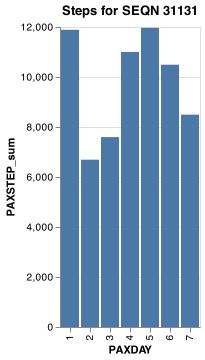

In [160]:
id = 2
alt.Chart(by_day.loc[by_day.SEQN == by_day.SEQN.unique()[id], :]).mark_bar().encode(
    x="PAXDAY:O", y="PAXSTEP_sum"
).properties(title=f"Steps for SEQN {by_day.SEQN.unique()[id]}")

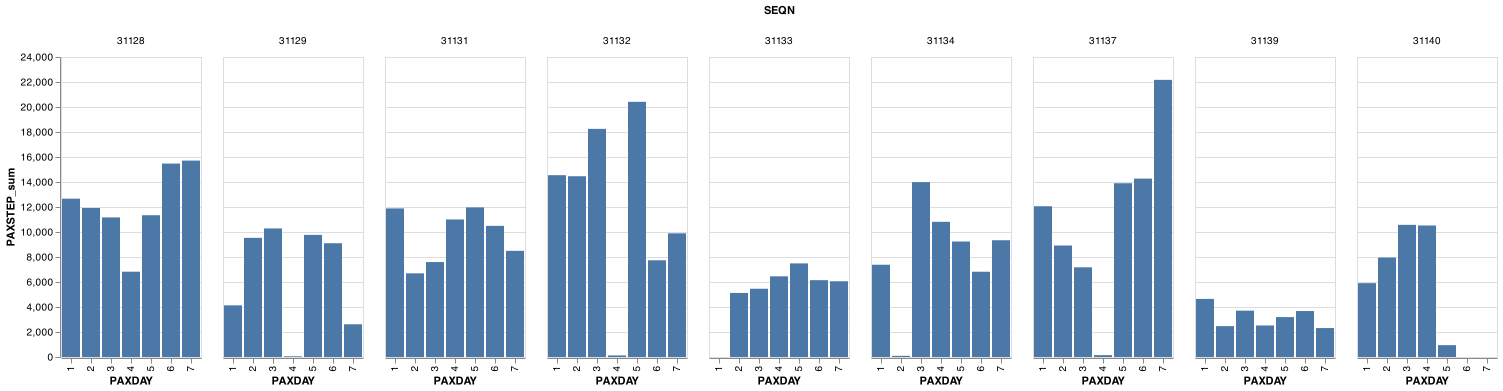

In [161]:
alt.Chart(by_day.loc[by_day.SEQN.isin(by_day.SEQN.unique()[:9]), :]).mark_bar().encode(
    x="PAXDAY:O", y="PAXSTEP_sum", column="SEQN:N"
).properties()

## Individual activity/steps

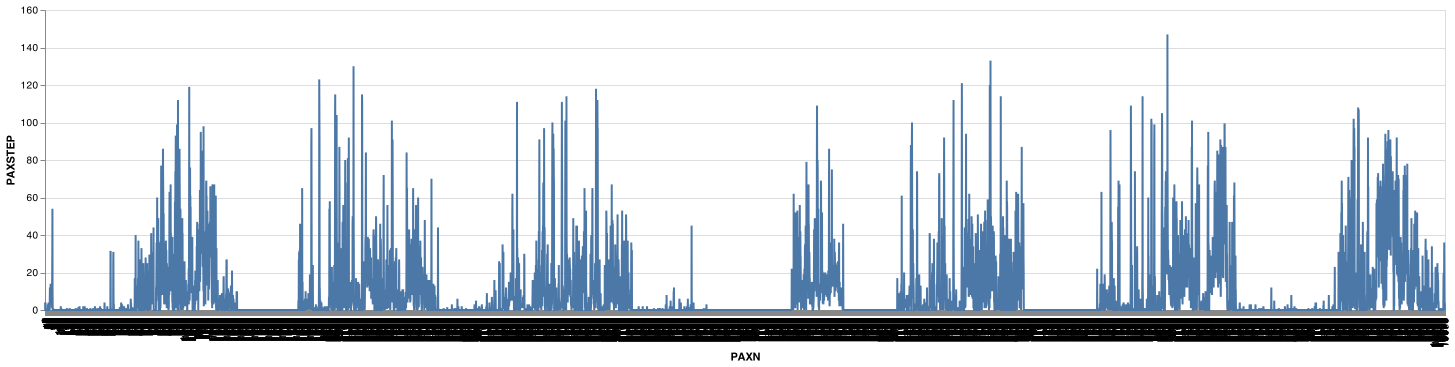

In [162]:
alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :]).mark_line().encode(
    x="PAXN:O", y="PAXSTEP"
).properties(width=1400)

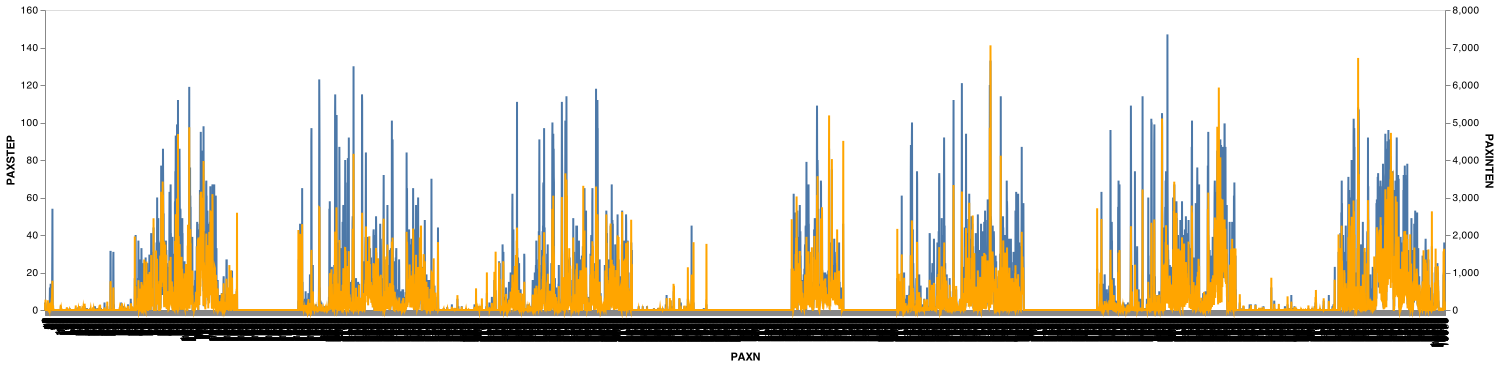

In [163]:
(
    alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_line()
    .encode(x="PAXN:O", y="PAXSTEP")
    + alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_line(color="orange")
    .encode(x="PAXN:O", y="PAXINTEN")
).properties(width=1400).resolve_scale(y="independent")

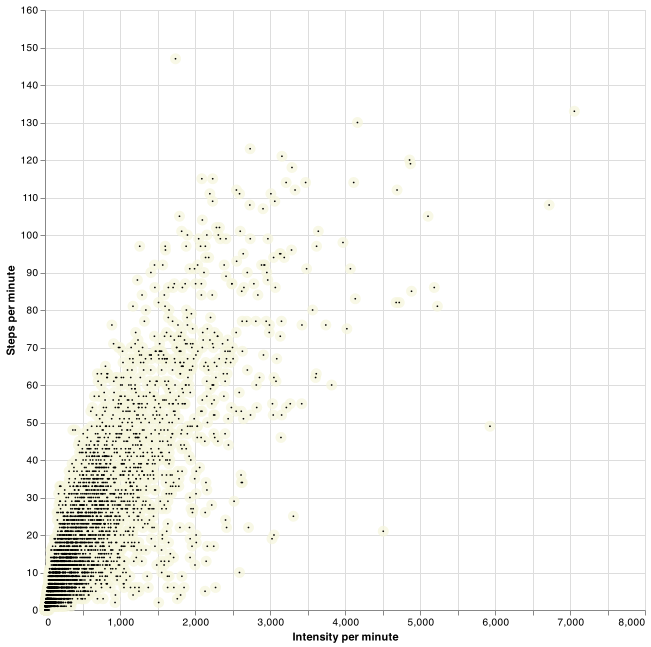

In [164]:
(
    alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_circle(opacity=0.7, color="#F5F5DC", size=120)
    .encode(
        alt.X("PAXINTEN:Q", title="Intensity per minute"),
        alt.Y("PAXSTEP:Q", title="Steps per minute"),
    )
    + alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_circle(opacity=1, color="black", size=3)
    .encode(x="PAXINTEN", y="PAXSTEP")
).properties(width=600, height=600)

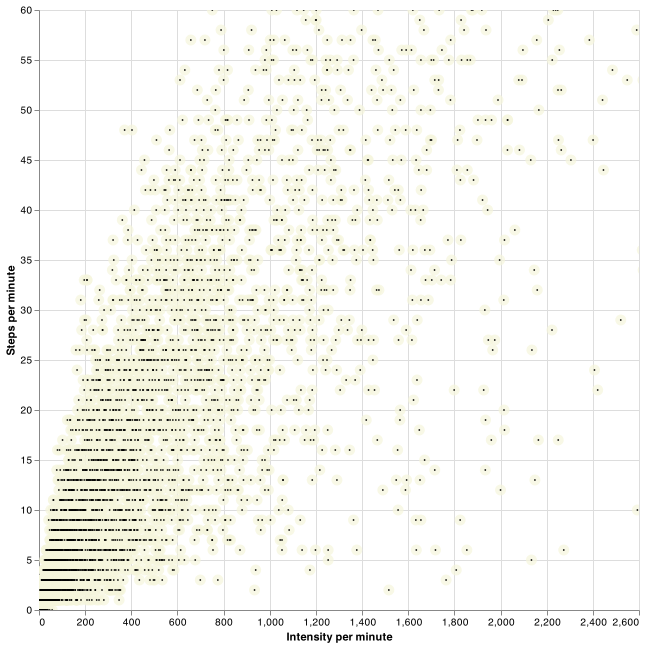

In [165]:
(
    alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_circle(clip=True, opacity=0.7, color="#F5F5DC", size=120)
    .encode(
        alt.X(
            "PAXINTEN:Q",
            title="Intensity per minute",
            scale=alt.Scale(domain=[0, 2500]),
        ),
        alt.Y("PAXSTEP:Q", title="Steps per minute", scale=alt.Scale(domain=[0, 60])),
    )
    + alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_circle(clip=True, opacity=1, color="black", size=3)
    .encode(x="PAXINTEN", y="PAXSTEP")
).properties(width=600, height=600)

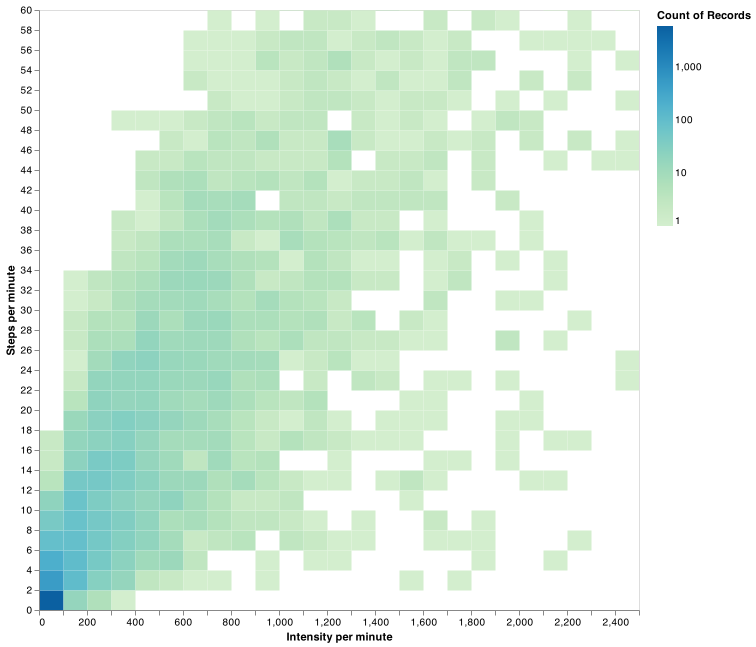

In [166]:
alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :]).mark_rect(clip=True).encode(
    alt.X(
        "PAXINTEN:Q",
        title="Intensity per minute",
        scale=alt.Scale(domain=[0, 2500]),
        bin=alt.Bin(maxbins=100),
    ),
    alt.Y(
        "PAXSTEP:Q",
        title="Steps per minute",
        scale=alt.Scale(domain=[0, 60]),
        bin=alt.Bin(maxbins=100),
    ),
    alt.Color("count():Q", scale=alt.Scale(scheme="greenblue", type="log")),
).properties(width=600, height=600)

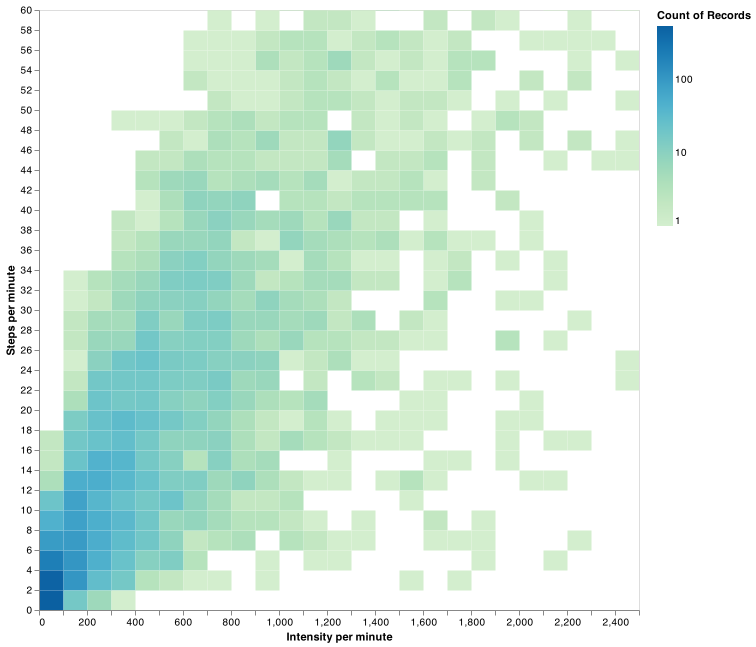

In [167]:
alt.Chart(
    paxraw.loc[
        (paxraw.SEQN == by_day.SEQN.unique()[0]) & (paxraw.PAXINTEN > 0) & (paxraw.PAXSTEP > 0),
        :,
    ]
).mark_rect(clip=True).encode(
    alt.X(
        "PAXINTEN:Q",
        title="Intensity per minute",
        scale=alt.Scale(domain=[0, 2500]),
        bin=alt.Bin(maxbins=100),
    ),
    alt.Y(
        "PAXSTEP:Q",
        title="Steps per minute",
        scale=alt.Scale(domain=[0, 60]),
        bin=alt.Bin(maxbins=100),
    ),
    alt.Color("count():Q", scale=alt.Scale(scheme="greenblue", type="log")),
).properties(
    width=600, height=600
)

## Activity plots for a single participant

In [168]:
person_active_counts = d_people_days.loc[
    :, ["SEQN", "worn_sum", "PAXINTEN_sum", "valid_day"]
].copy()

In [169]:
person_active_counts.columns = ["SEQN", "worn_minutes", "activity_counts", "valid_day"]

In [170]:
person_active_counts.head()

,SEQN,worn_minutes,activity_counts,valid_day
0,31128,1276.0,377456,1
1,31128,1009.0,308309,1
2,31128,1273.0,324734,1
3,31128,599.0,229846,0
4,31128,911.0,304957,1


In [171]:
person_active_counts_summary = (
    person_active_counts.loc[person_active_counts.valid_day == 1, :]
    .groupby(["SEQN"])
    .agg({"worn_minutes": np.mean, "activity_counts": np.mean, "valid_day": "count"})
)
person_active_counts_summary.columns = [
    "daily_worn_minutes_mean",
    "daily_activity_count_sum_mean",
    "n_valid_days",
]
person_active_counts_summary.head()

,daily_worn_minutes_mean,daily_activity_count_sum_mean,n_valid_days
SEQN,,,
31128,1140.166667,365314.000000,6
31129,923.500000,271898.250000,4
31131,897.500000,261294.333333,6
31132,898.200000,473383.400000,5
31133,881.200000,212055.200000,5


In [172]:
person_active_counts_summary.shape

(6927, 3)

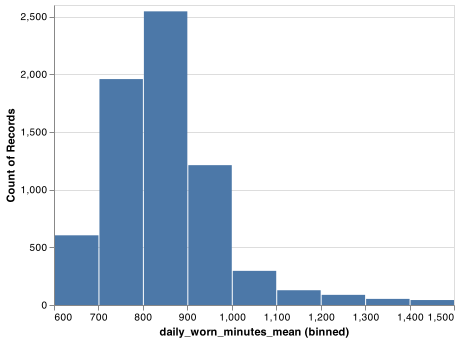

In [173]:
alt.Chart(person_active_counts_summary).mark_bar().encode(
    alt.X("daily_worn_minutes_mean:Q", bin=True),
    y="count()",
)

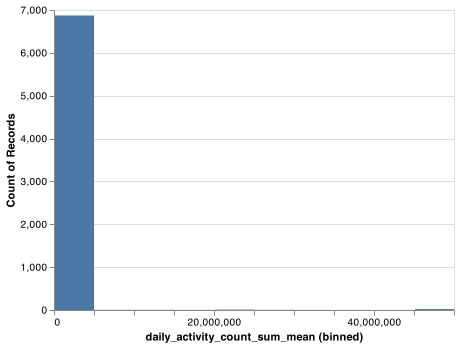

In [174]:
alt.Chart(person_active_counts_summary).mark_bar().encode(
    alt.X("daily_activity_count_sum_mean:Q", bin=True),
    y="count()",
)

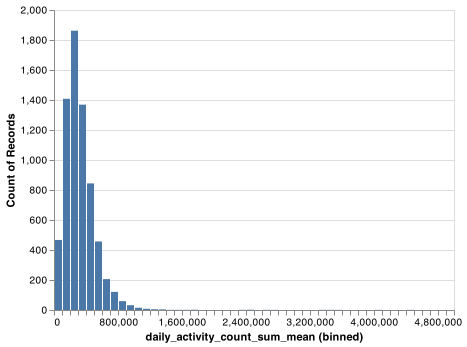

In [175]:
alt.Chart(person_active_counts_summary).mark_bar(clip=True).encode(
    alt.X(
        "daily_activity_count_sum_mean:Q",
        scale=alt.Scale(domain=[0, 5000000]),
        bin=alt.Bin(maxbins=500),
    ),
    y="count()",
)

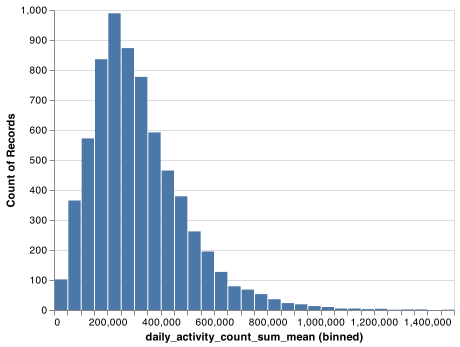

In [176]:
alt.Chart(person_active_counts_summary).mark_bar(clip=True).encode(
    alt.X(
        "daily_activity_count_sum_mean:Q",
        scale=alt.Scale(domain=[0, 1500000]),
        bin=alt.Bin(maxbins=1000),
    ),
    y="count()",
)

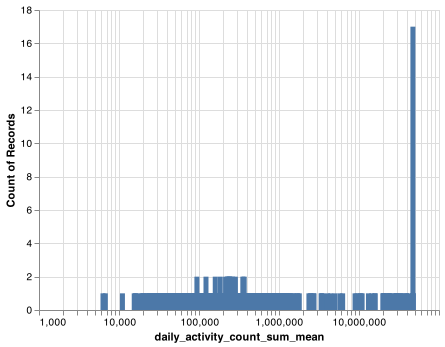

In [177]:
alt.Chart(person_active_counts_summary).mark_bar().encode(
    alt.X("daily_activity_count_sum_mean:Q", scale=alt.Scale(type="log")),
    y="count()",
)

In [178]:
person_active_counts_summary["daily_activity_count_sum_mean_log"] = np.log10(
    person_active_counts_summary["daily_activity_count_sum_mean"]
)

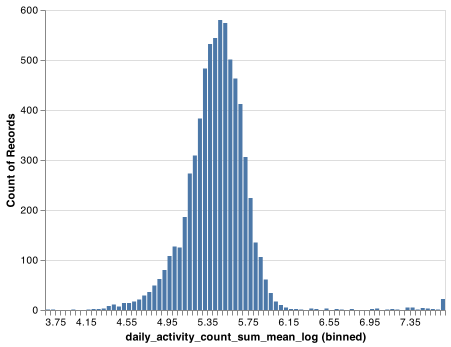

In [179]:
alt.Chart(person_active_counts_summary).mark_bar(clip=True).encode(
    alt.X(
        "daily_activity_count_sum_mean_log:Q",
        scale=alt.Scale(),
        bin=alt.Bin(maxbins=100),
    ),
    y="count()",
)

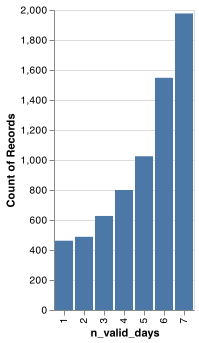

In [180]:
alt.Chart(person_active_counts_summary).mark_bar().encode(
    alt.X("n_valid_days:O"),
    y="count()",
)

In [181]:
# clear the crazy data
person_active_counts_summary = person_active_counts_summary.loc[
    person_active_counts_summary.daily_activity_count_sum_mean < 1500000, :
].copy()

In [182]:
cuts = 3
person_active_counts_summary["activity_tertile"] = pd.qcut(
    person_active_counts_summary.daily_activity_count_sum_mean,
    q=cuts,
    labels=range(1, cuts + 1),
)

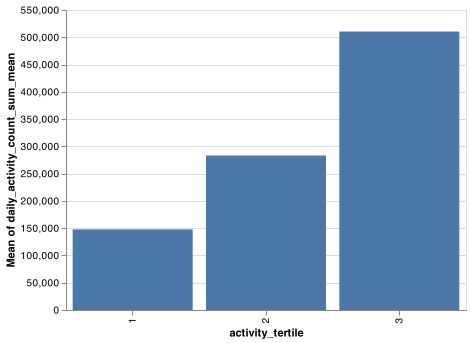

In [183]:
alt.Chart(person_active_counts_summary).mark_bar(clip=True).encode(
    alt.X("activity_tertile:O", scale=alt.Scale(), bin=False),
    y="mean(daily_activity_count_sum_mean)",
).properties(width=400)

## Examine the filters for valid people

In [184]:
d_people.loc[
    (d_people.zero_steps_with_intensity_sum > 10)
    | (d_people.too_many_steps_sum > 10)
    | (d_people.max_intensity_sum > 10),
    :,
].head(20)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
31180,91,709,0,0,0,9092,1,37285.571429,51537.714286,3,8.668543e+04
31192,30,345,0,0,0,10080,1,13657.000000,18503.714286,1,3.835557e+04
31254,26,1129,0,0,0,10080,1,72155.000000,91213.428571,5,1.640576e+05
31257,42,496,0,0,0,6904,1,14367.800000,23388.600000,5,6.801540e+04
31263,10080,0,10080,10080,1,10080,1,0.000000,0.000000,7,4.718448e+07
31301,60,498,0,0,0,8950,1,28979.428571,34453.714286,2,6.382729e+04
31307,135,0,0,10080,1,10080,1,2625.142857,3802.714286,4,3.338937e+05
31349,13,0,0,0,0,10080,1,7041.285714,7722.285714,6,2.540803e+05
31415,42,279,0,0,0,9114,1,23109.428571,25605.142857,1,4.149614e+04


In [185]:
d_people.loc[
    (d_people.zero_steps_with_intensity_sum > 10)
    | (d_people.too_many_steps_sum > 10)
    | (d_people.max_intensity_sum > 10)
    | (d_people.out_of_calibration_last),
    :,
].head(20)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
31154,0,0,0,10080,1,0,0,3773.142857,6016.000000,7,1.001300e+05
31163,3,0,0,10080,1,0,0,4451.142857,5287.285714,6,1.680881e+05
31180,91,709,0,0,0,9092,1,37285.571429,51537.714286,3,8.668543e+04
31181,3,0,0,10080,1,0,0,2693.857143,4333.000000,7,1.222759e+05
31192,30,345,0,0,0,10080,1,13657.000000,18503.714286,1,3.835557e+04
31193,0,0,0,10080,1,0,0,9644.142857,10371.857143,2,3.998269e+05
31203,0,0,0,10080,1,0,0,6299.428571,7980.142857,7,2.749851e+05
31211,0,0,0,10080,1,0,0,5260.571429,6351.000000,6,2.377843e+05
31230,0,0,0,10080,1,0,0,3711.857143,4409.428571,2,1.325093e+05


In [186]:
d_people.loc[
    (d_people.zero_steps_with_intensity_sum > 10)
    | (d_people.too_many_steps_sum > 10)
    | (d_people.max_intensity_sum > 10)
    | (d_people.out_of_calibration_last)
    | (d_people.unreliable_last),
    :,
].head(20)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
31154,0,0,0,10080,1,0,0,3773.142857,6016.000000,7,1.001300e+05
31163,3,0,0,10080,1,0,0,4451.142857,5287.285714,6,1.680881e+05
31180,91,709,0,0,0,9092,1,37285.571429,51537.714286,3,8.668543e+04
31181,3,0,0,10080,1,0,0,2693.857143,4333.000000,7,1.222759e+05
31192,30,345,0,0,0,10080,1,13657.000000,18503.714286,1,3.835557e+04
31193,0,0,0,10080,1,0,0,9644.142857,10371.857143,2,3.998269e+05
31203,0,0,0,10080,1,0,0,6299.428571,7980.142857,7,2.749851e+05
31211,0,0,0,10080,1,0,0,5260.571429,6351.000000,6,2.377843e+05
31230,0,0,0,10080,1,0,0,3711.857143,4409.428571,2,1.325093e+05


In [187]:
d_unreliable = d_people.loc[
    (d_people.zero_steps_with_intensity_sum > 10)
    | (d_people.too_many_steps_sum > 10)
    | (d_people.max_intensity_sum > 10)
    | (d_people.out_of_calibration_last)
    | (d_people.unreliable_sum > 10)
    | (d_people.steps_filtered_500_sum > 200000),
    :,
]
d_unreliable.head(20)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
31154,0,0,0,10080,1,0,0,3773.142857,6016.000000,7,1.001300e+05
31163,3,0,0,10080,1,0,0,4451.142857,5287.285714,6,1.680881e+05
31180,91,709,0,0,0,9092,1,37285.571429,51537.714286,3,8.668543e+04
31181,3,0,0,10080,1,0,0,2693.857143,4333.000000,7,1.222759e+05
31192,30,345,0,0,0,10080,1,13657.000000,18503.714286,1,3.835557e+04
31193,0,0,0,10080,1,0,0,9644.142857,10371.857143,2,3.998269e+05
31203,0,0,0,10080,1,0,0,6299.428571,7980.142857,7,2.749851e+05
31211,0,0,0,10080,1,0,0,5260.571429,6351.000000,6,2.377843e+05
31230,0,0,0,10080,1,0,0,3711.857143,4409.428571,2,1.325093e+05


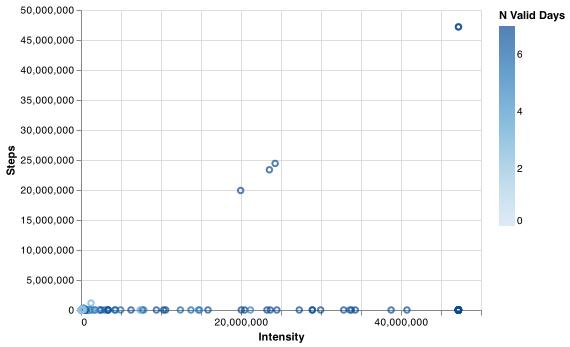

In [188]:
alt.Chart(d_unreliable).mark_point().encode(
    alt.X("PAXINTEN_sum", title="Intensity"),
    alt.Y("steps_filtered_500_sum", title="Steps"),
    alt.Color("valid_day", title="N Valid Days"),
)

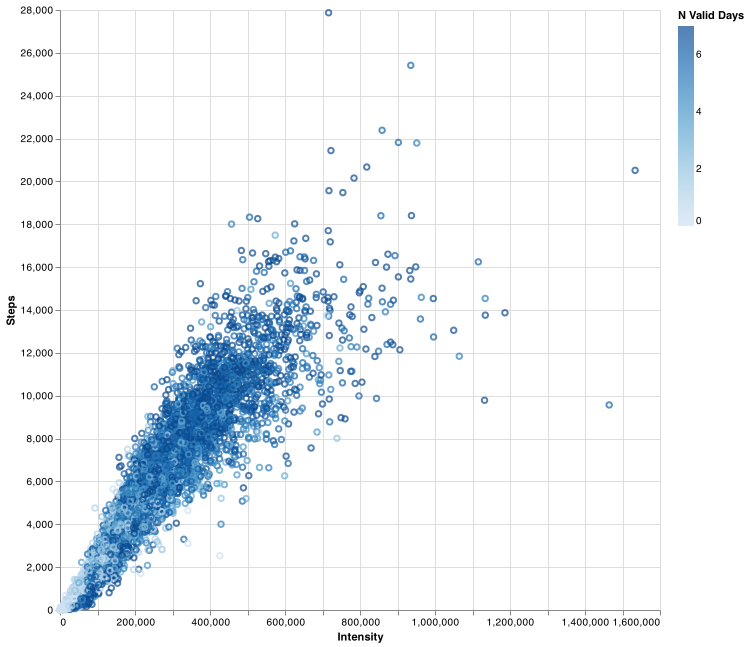

In [189]:
alt.Chart(d_reliable).mark_point().encode(
    alt.X("PAXINTEN_sum", title="Intensity"),
    alt.Y("steps_filtered_500_sum", title="Steps"),
    alt.Color("valid_day", title="N Valid Days"),
).properties(width=600, height=600)

# Correlation of steps and intensity

In [190]:
results = smf.ols("steps_filtered_500_sum ~ PAXINTEN_sum + 0", data=d_reliable).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     steps_filtered_500_sum   R-squared (uncentered):                   0.952
Model:                                OLS   Adj. R-squared (uncentered):              0.952
Method:                     Least Squares   F-statistic:                          1.361e+05
Date:                    Thu, 23 Feb 2023   Prob (F-statistic):                        0.00
Time:                            10:31:57   Log-Likelihood:                         -59566.
No. Observations:                    6863   AIC:                                  1.191e+05
Df Residuals:                        6862   BIC:                                  1.191e+05
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
PAXINTEN_sum     0.0219   5.95e-05    368.890      0.000       0.022       0.022
==============================================================================
Omnibus:                     3292.380   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           123330.142
Skew:                          -1.631   Prob(JB):                         0.00
Kurtosis:                      23.510   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

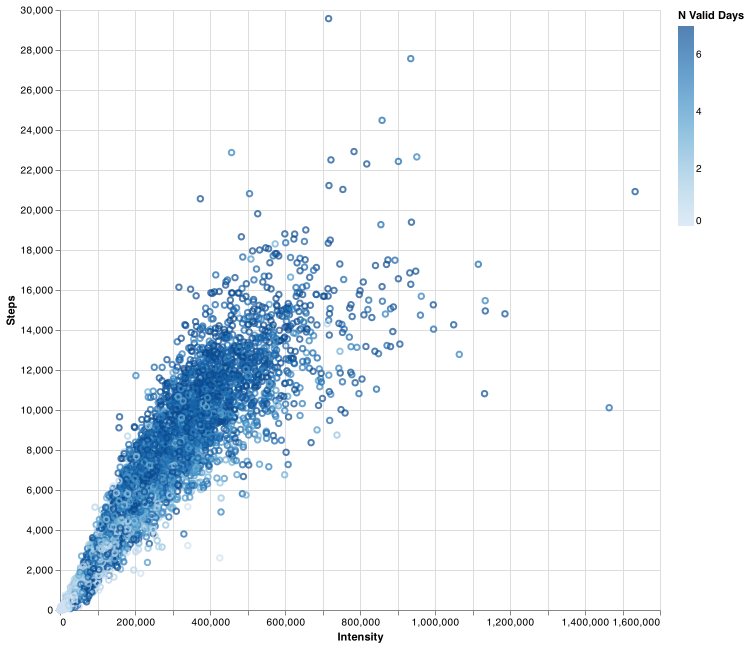

In [191]:
alt.Chart(d_reliable).mark_point().encode(
    alt.X("PAXINTEN_sum", title="Intensity"),
    alt.Y("steps_filtered_300_sum", title="Steps"),
    alt.Color("valid_day", title="N Valid Days"),
).properties(width=600, height=600)

In [192]:
results = smf.ols("steps_filtered_300_sum ~ PAXINTEN_sum + 0", data=d_reliable).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     steps_filtered_300_sum   R-squared (uncentered):                   0.945
Model:                                OLS   Adj. R-squared (uncentered):              0.945
Method:                     Least Squares   F-statistic:                          1.178e+05
Date:                    Thu, 23 Feb 2023   Prob (F-statistic):                        0.00
Time:                            10:31:59   Log-Likelihood:                         -60936.
No. Observations:                    6863   AIC:                                  1.219e+05
Df Residuals:                        6862   BIC:                                  1.219e+05
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
PAXINTEN_sum     0.0249   7.26e-05    343.254      0.000       0.025       0.025
==============================================================================
Omnibus:                     3685.092   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120091.436
Skew:                          -1.974   Prob(JB):                         0.00
Kurtosis:                      23.109   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

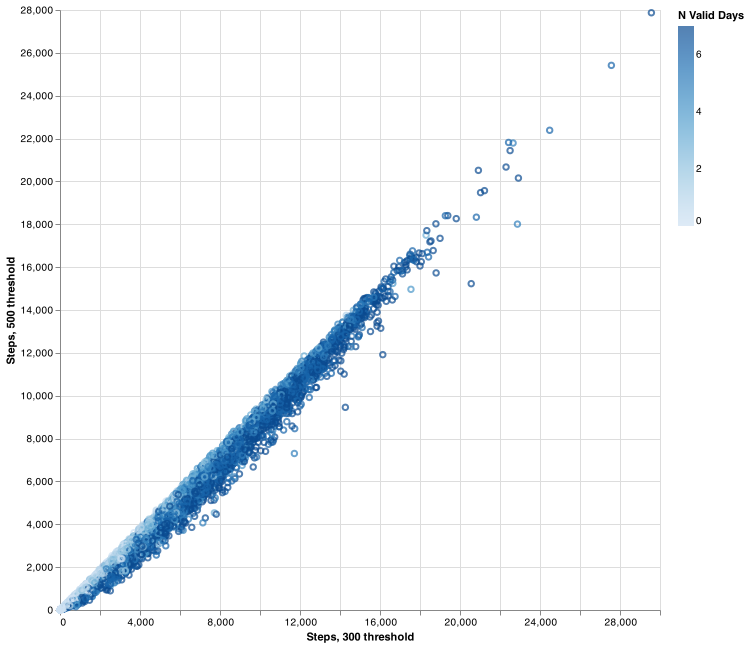

In [193]:
alt.Chart(d_reliable).mark_point().encode(
    alt.X("steps_filtered_300_sum", title="Steps, 300 threshold"),
    alt.Y("steps_filtered_500_sum", title="Steps, 500 threshold"),
    alt.Color("valid_day", title="N Valid Days"),
).properties(width=600, height=600)